In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.wigner import wigner_3j,wigner_6j
import lmfit
from lmfit import Parameters,minimize
import copy
from scipy import signal

In [2]:
def kronecker(a,b):         # Kronecker delta function
    if a==b:
        return 1
    else:
        return 0

def b2a_matrix(a,b,S=1/2):
    if not kronecker(a['K'],b['K'])*kronecker(a['J'],b['J']):
        return 0
    else:
        return (-1)**(b['N']-S+a['P'])*np.sqrt(2*b['N']+1)*wigner_3j(a['J'],S,b['N'],a['P'],-a['Sigma'],-a['K'])
    
def convert_abBJ(input_qnumbers,output_qnumbers,S=1/2):
    input_keys = list(input_qnumbers)
    output_keys = list(output_qnumbers)
    input_size = len(input_qnumbers[input_keys[0]])
    output_size = len(output_qnumbers[output_keys[0]])
    basis_matrix = np.zeros((output_size,input_size))
    for i in range(output_size):
        for j in range(input_size):
            if 'N' in input_keys: #Convert case (b) to (a)
                a_qnumbers = {q:output_qnumbers[q][i] for q in output_keys}
                b_qnumbers = {q:input_qnumbers[q][j] for q in input_keys}
            else:
                b_qnumbers = {q:output_qnumbers[q][i] for q in output_keys}
                a_qnumbers = {q:input_qnumbers[q][j] for q in input_keys}
            basis_matrix[i,j] = b2a_matrix(a_qnumbers,b_qnumbers,S=S)
    return basis_matrix

def q_numbers_even_bBJ(N_range,K_mag,S=1/2,I_list=[0,1/2],M_values='all',M_range=[]):
    IM=I_list[0]
    iH = I_list[-1]
    Nmin,Nmax=N_range[0],N_range[-1]
    K_mag = abs(K_mag)
    if Nmin<K_mag:
        print('Nmin must be >= |K|')
        Nmin=abs(K_mag)
    q_str = ['K','N','J','F','M']
    I = max(IM,iH)
    q_numbers = {}
    for q in q_str:
        q_numbers[q] = []
    for N in np.arange(Nmin,Nmax+1,1):
        for J in np.arange(abs(N-S),abs(N+S)+1,1):
            for F in np.arange(abs(J-I),abs(J+I)+1,1):
                if M_values=='none':
                    for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                        M=abs(F)%1
                        values = [K,N,J,F,M]
                        for q,val in zip(q_str,values):
                            q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
                else:
                    if M_values=='all' or M_values=='custom':
                        Mmin = -F
                    elif M_values=='pos':
                        Mmin = abs(F) % 1
                    for M in np.arange(Mmin,F+1,1):
                        if (M_values=='custom' and M in M_range) or (M_values=='all') or (M_values=='pos'):
                            for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                                values = [K,N,J,F,M]
                                for q,val in zip(q_str,values):
                                    q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
                        elif M_values=='custom' and M not in M_range:
                            continue
    return q_numbers

def q_numbers_even_aBJ(N_range,K_mag=1,S=1/2,I_list=[0,1/2],M_values='all',P_values=[1/2],M_range=[]):
    IM=I_list[0]
    iH = I_list[-1]
    Nmin,Nmax=N_range[0],N_range[-1]
    Jmin = abs(Nmin-S)
    Jmax = abs(Nmax+S)
    K_mag = abs(K_mag)
    if Nmin<K_mag:
        print('Nmin must be >= |K|')
        Nmin=abs(K_mag)
    q_str = ['K','Sigma','P','J','F','M']
    q_numbers = {}
    for q in q_str:
        q_numbers[q] = []
    I = max(IM,iH)
    for J in np.arange(Jmin,Jmax+1,1):
        for F in np.arange(abs(J-I),abs(J+I)+1,1):
            if M_values=='none':
                for Sigma in np.arange(-abs(S),abs(S)+1,1):
                    for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                        P=K+Sigma
                        if abs(P) not in P_values:
                            continue
                        elif J < abs(P):
                            continue
                        else:
                            M=abs(F)%1
                            values = [K,Sigma,P,J,F,M]
                        for q,val in zip(q_str,values):
                            q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
            else:
                if M_values=='all' or M_values=='custom':
                    Mmin = -F
                elif M_values=='pos':
                    Mmin = abs(F) % 1
                for M in np.arange(Mmin,F+1,1):
                    if (M_values=='custom' and M in M_range) or (M_values=='all') or (M_values=='pos'):
                        for Sigma in np.arange(-abs(S),abs(S)+1,1):
                            for K in {True:[0], False:[-K_mag,K_mag]}[K_mag==0]:
                                P=K+Sigma
                                if abs(P) not in P_values:
                                    continue
                                elif J < abs(P):
                                    continue
                                else:
                                    values = [K,Sigma,P,J,F,M]
                                for q,val in zip(q_str,values):
                                    q_numbers[q].append(val+0)    #looks weird but adding 0 converts -0 to 0
                    elif M_values=='custom' and M not in M_range:
                        continue
    return q_numbers

def write_state(vector,qn,case):
    for index in np.nonzero(vector)[0]:
        v={q:qn[q][index] for q in qn}
        coeff = vector[index]
        if case == 'bBS':
            print(' {} |K={},N={},G={},F1={},F={},M={}> \n'.format(coeff,v['K'],v['N'],v['G'],v['F1'],v['F'],v['M']))
        elif case == 'bBJ':
            print(' {} |K={},N={},J={},F={},M={}> \n'.format(coeff,v['K'],v['N'],v['J'],v['F'],v['M']))
        elif case == 'aBJ':
            print(' {} |K={},\u03A3={},P={},J={},F={},M={}> \n'.format(coeff,v['K'],v['Sigma'],v['P'],v['J'],v['F'],v['M']))
            
def build_operator(q_in,q_out,matrix_element,symbolic=False):
    q_str_in = list(q_in)
    q_str_out = list(q_out)
    size_in = len(q_in[q_str_in[0]])
    size_out = len(q_out[q_str_out[0]])
    operator = np.zeros((size_out,size_in))
    for i in range(size_out):
        for j in range(size_in):
            state_out = {q+'0':q_out[q][i] for q in q_out}
            state_in = {q+'1':q_in[q][j] for q in q_in}
            q_args = {**state_out,**state_in}
            operator[i,j] = matrix_element(**q_args)
            if symbolic:
                operator[i,j] = sy.nsimplify(operator[i,j])
    if symbolic:
        operator = sy.Matrix(operator)
    return operator

In [3]:
def q_numbers_A010(N_range,l=1,L=1,S=1/2,P_values=[1/2,3/2,5/2],Omega_values=[1/2,3/2]):
    q_str = ['L','l','Sigma','K','Omega','P','J']
    q_numbers = {}
    for q in q_str:
        q_numbers[q] = []
    if L==0:
        Lvals = [0]
    else:
        Lvals = [-L,L]
    if l==0:
        lvals = [0]
    else:
        lvals = [-l,l]
    if S==0:
        Svals = [0]
    else:
        Svals = [-S,S]
    Nmin,Nmax=N_range[0],N_range[-1]
    if Nmin<abs(l):
        print('Nmin must be >= |K|')
        Nmin=abs(l)
    Jmin = abs(Nmin-S)
    Jmax = abs(Nmax+S)
    for J in np.arange(Jmin,Jmax+1,1):
        for _L in Lvals:
            for _l in lvals:
                K = _L+_l
                for _S in Svals:
                    Omega = _S+_L
                    if abs(Omega) not in Omega_values:
                        continue
                    P= _L+_l+_S
                    if abs(P) not in P_values:
                        continue
                    elif J < abs(P):
                        continue
                    else:
                        values = [_L,_l,_S,K,Omega,P,J]
                        for q,val in zip(q_str,values):
                                q_numbers[q].append(val+0)
    return q_numbers

def q_numbers_X010(N_range,l=1,L=0,S=1/2):
    q_str = ['L','l','K','N','J']
    q_numbers = {}
    for q in q_str:
        q_numbers[q] = []
    if L==0:
        Lvals = [0]
    else:
        Lvals = [-L,L]
    if l==0:
        lvals = [0]
    else:
        lvals = [-l,l]
    Nmin,Nmax=N_range[0],N_range[-1]
    if Nmin<abs(l):
        print('Nmin must be >= |K|')
        Nmin=abs(l)
    for N in N_range:
        for J in np.arange(abs(N-S),abs(N+S)+1,1):
            for _L in Lvals:
                for _l in lvals:
                    K = _L+_l
                    values = [_L,_l,K,N,J]
                    for q,val in zip(q_str,values):
                            q_numbers[q].append(val+0)
    return q_numbers

def Parity_b(L0,l0,K0,N0,J0,L1,l1,K1,N1,J1,S=1/2):
    if not kronecker(N0,N1)*kronecker(K0,-K1)*kronecker(L0,-L1)*kronecker(l0,-l1)*kronecker(J0,J1):
        return 0
    else:
        return (-1)**(N0-l0)
    
def Parity_a(L0,l0,Sigma0,K0,Omega0,P0,J0,L1,l1,Sigma1,K1,Omega1,P1,J1,S=1/2):
    if not kronecker(J0,J1)*kronecker(K0,-K1)*kronecker(L0,-L1)*kronecker(l0,-l1)*kronecker(Sigma0,-Sigma1)*kronecker(Omega0,-Omega1):
        return 0
    else:
        return (-1)**(J0-S-l0)
    
def lD_a(L0,l0,Sigma0,K0,Omega0,P0,J0,L1,l1,Sigma1,K1,Omega1,P1,J1,S=1/2):
    if not kronecker(J0,J1)*kronecker(l0,-l1)*kronecker(Sigma0,Sigma1)*kronecker(L0,L1):
        return 0
    else:
        return 1
    
def ew_a(L0,l0,Sigma0,K0,Omega0,P0,J0,L1,l1,Sigma1,K1,Omega1,P1,J1,S=1/2):
    if not kronecker(J0,J1)*kronecker(J0,1/2)*kronecker(Sigma0,-Sigma1)*kronecker(L0,-L1)*kronecker(l0,-l1):
        return 0
    else:
        return (-1)**(J0-S-l0)
    
def p_lD_b(L0,l0,K0,N0,J0,L1,l1,K1,N1,J1,S=1/2):
    if not kronecker(J0,J1)*kronecker(L0,L1)*kronecker(N0,N1)*(not kronecker(l0,l1)):
        return 0
    else:
        return sum([(-1)**(J0+N1+S)*-np.sqrt(10/6)*wigner_6j(N0,S,J0,S,N1,1)*np.sqrt(S*(S+1)*(2*S+1))*\
            np.sqrt(3)*(-1)**(1+N0+N1)*wigner_6j(2,1,1,N1,N0,N0)*np.sqrt(N0*(N0+1)*(2*N0+1))*\
            (-1)**(N0-K0)*wigner_3j(N0,2,N1,-K0,2*q,K1)*np.sqrt((2*N0+1)*(2*N1+1))*kronecker(K0,K1+2*q) for q in [-1,1]])


def q_lD_b(L0,l0,K0,N0,J0,L1,l1,K1,N1,J1,S=1/2):
    if not kronecker(J0,J1)*kronecker(L0,L1)*kronecker(N0,N1)*(not kronecker(l0,l1)):
        return 0
    else:
        return sum([(-1)**(2*J0)*np.sqrt((2*J1+1))*(-1)**(S+J1+N0)*wigner_6j(N1,J1,S,J0,N0,0)*\
            np.sqrt(5)*(-1)**(N0+N1)*wigner_6j(2,2,0,N1,N0,N0)*(-1)**(N0-K0)*wigner_3j(N0,2,N1,-K0,2*q,K1)*\
            1/(2*np.sqrt(6))*np.sqrt((2*N0-1)*(2*N0)*(2*N0+1)*(2*N0+2)*(2*N0+3))*np.sqrt((2*N0+1)*(2*N1+1))*kronecker(K0,K1+2*q) for q in [-1,1]]) #there is ambiguity over the inclusion of extra sqrt(2J0+1)
    
def LD_a(L0,l0,Sigma0,K0,Omega0,P0,J0,L1,l1,Sigma1,K1,Omega1,P1,J1,S=1/2):
    if not kronecker(J0,J1)*kronecker(l0,l1):
        return 0
    else:
        return (sum([np.sqrt((2*J0+1)*(J0+1)*J0*(2*S+1)*(S+1)*S)*kronecker(L1,L0+2*q)*(-1)**(J0-P0)*wigner_3j(J0,1,J1,-P0,-q,P1)*(-1)**(S-Sigma0)*wigner_3j(S,1,S,-Sigma0,q,Sigma1) for q in [-1,1]]))
    
def Brot_a(L0,l0,Sigma0,K0,Omega0,P0,J0,L1,l1,Sigma1,K1,Omega1,P1,J1,S=1/2):
    if not kronecker(l0,l1)*kronecker(J0,J1):
        return 0
    else:
        return kronecker(Sigma0,Sigma1)*kronecker(P0,P1)*(J0*(J0+1)+S*(S+1)-(P0)**2-(Sigma0)**2-0*2*P0*Sigma0)-\
            sum([2*(-1)**(J0-(P0)+S-Sigma0)*np.sqrt((2*J0+1)*J0*(J0+1)*(2*S+1)*S*(S+1))*\
            wigner_3j(J0,1,J1,-P0,q,P1)*wigner_3j(S,1,S,-Sigma0,q,Sigma1) for q in [-1,1]])
    
def Brot_b(L0,l0,K0,N0,J0,L1,l1,K1,N1,J1,S=1/2):
    if not kronecker(J0,J1)*kronecker(L0,L1)*kronecker(l0,l1)*kronecker(N0,N1):
        return 0
    else:
        return N0*(N0+1)

def SR_b(L0,l0,K0,N0,J0,L1,l1,K1,N1,J1,S=1/2):
    if not kronecker(J0,J1)*kronecker(L0,L1)*kronecker(l0,l1)*kronecker(N0,N1):
        return 0
    else:
        return (-1)**(N1+J0+S)*np.sqrt(S*(S+1)*(2*S+1)*N0*(N0+1)*(2*N0+1))*\
            wigner_6j(N0,S,J0,S,N1,1)
    
def TDM_vibronic_a_noM(L0,l0,K0,Sigma0,Omega0,P0,J0,L1,l1,K1,Sigma1,Omega1,P1,J1,S=1/2):
    if not kronecker(Sigma0,Sigma1)*kronecker(l0,l1):
        return 0
    else:
        delta_L = L0-L1
        TDM = 1/np.sqrt(2*J1+1)*\
            sum([np.sqrt((2*J0+1)*(2*J1+1))*(-1)**(J0-P0)*wigner_3j(J0,1,J1,-P0,_q,P1)*kronecker(delta_L,_q) for _q in [-1,1]])
        return TDM

def write_state(vector,qn,case):
    for index in np.nonzero(vector)[0]:
        v={q:qn[q][index] for q in qn}
        coeff = vector[index]
        if case == 'b':
            print(' {} |L={},l={},K={},N={},J={}> \n'.format(coeff,v['L'],v['l'],v['K'],v['N'],v['J']))
        elif case == 'a':
            print(' {} |L={},l={},Sigma={},K={},P={},J={}> \n'.format(coeff,v['L'],v['l'],v['Sigma'],v['K'],v['P'],v['J']))
    
def state_str(vector,qn,case,parity=None):
    if parity is None:
        state = ''
        for index in np.nonzero(vector)[0]:
            v={q:qn[q][index] for q in qn}
            coeff = np.round(vector[index],2)
            if case == 'b':
                state+='{}|'.format(coeff)
                state+='$\\Lambda$={}, $\\ell$={}> '.format(v['L'],v['l'])
            elif case == 'a':
                if v['Omega']<0:
                    continue
                state+='{}|'.format(coeff)
                state+='$\\Lambda$={}, $\\ell$={}, $\\Sigma$={}> '.format(v['L'],v['l'],v['Sigma'])
    else:
        state = '$\\mathcal{{P}}$=${},$'.format({True:'+',False:'-'}[parity>0])
        first = True
        for index in np.nonzero(vector)[0]:
            v={q:qn[q][index] for q in qn}
            coeff = vector[index]
            if case=='a':
                if v['Omega']<0:
                    continue
                if first:
                    first=False
                    sgn = np.sign(coeff)
                else:
                    state+= '${}$'.format({True:'+', False:'-'}[coeff*sgn>0])
                K = v['L'] + v['l']
                if K==0:
                    state+='$^2\\Sigma_{{1/2}}$'
                if K==2:
                    state+='$^2\\Delta_{{3/2}}$'
                if K==-2:
                    print('uhhh')
            elif case=='b':
                if v['l']<0:
                    continue
                if first:
                    first=False
                    sgn = np.sign(coeff)
                else:
                    state+= '${}$'.format({True:'+', False:'-'}[coeff*sgn>0])
                state+='$N$={}'.format(v['N'])
        state+=', $J$={}'.format(v['J'])
        return state

In [4]:
qnA = q_numbers_A010([1,2],l=1,L=1,S=1/2,Omega_values=[1/2])
qnXb = q_numbers_X010([1,2],l=1,L=0,S=1/2)
qnXa = q_numbers_A010([1,2],l=1,L=0,S=1/2,P_values=[1/2,3/2])

In [6]:
Pb = build_operator(qnXb,qnXb,Parity_b)
Pa = build_operator(qnA,qnA,Parity_a)
qlD = build_operator(qnXb,qnXb,q_lD_b)
plD = build_operator(qnXb,qnXb,p_lD_b)
LDa = build_operator(qnA,qnA,LD_a)
lDa = build_operator(qnA,qnA,lD_a)
ewa = build_operator(qnA,qnA,ew_a)
b2a = convert_abBJ(qnXb,qnXa,S=1/2)
TDM = build_operator(qnXa,qnA,TDM_vibronic_a_noM)
Rota = build_operator(qnA,qnA,Brot_a)
Rotb = build_operator(qnXb,qnXb,Brot_b)
SRb = build_operator(qnXb,qnXb,SR_b)

In [1301]:
Hb = -0.0004*Pb+0.25*Rotb-0.003*SRb
Ha = -0.44*LDa+0.25*Rota*0-0.016*lDa*0-0.016*Pa
Hdp = 0.25*Rota-0.016*Pa

In [1302]:
qnA

{'L': [-1, 1, -1, -1, 1, 1, -1, -1, 1, 1],
 'l': [1, -1, -1, 1, -1, 1, -1, 1, -1, 1],
 'Sigma': [0.5, -0.5, 0.5, 0.5, -0.5, -0.5, 0.5, 0.5, -0.5, -0.5],
 'K': [0, 0, -2, 0, 0, 2, -2, 0, 0, 2],
 'Omega': [-0.5, 0.5, -0.5, -0.5, 0.5, 0.5, -0.5, -0.5, 0.5, 0.5],
 'P': [0.5, -0.5, -1.5, 0.5, -0.5, 1.5, -1.5, 0.5, -0.5, 1.5],
 'J': [0.5, 0.5, 1.5, 1.5, 1.5, 1.5, 2.5, 2.5, 2.5, 2.5]}

In [1303]:
Pvals_b,Pvecs_b = np.linalg.eigh(Pb)
Pvals_a, Pvecs_a = np.linalg.eigh(Pa)
Hvals_a, Hvecs_a = np.linalg.eigh(Ha)
Hvals_b, Hvecs_b = np.linalg.eigh(Hb)
Hvals_dp, Hvecs_dp = np.linalg.eigh(Hdp)
Pvecs_b=np.round(Pvecs_b.T,6)
Pvecs_a=np.round(Pvecs_a.T,6)
Hvecs_a=np.round(Hvecs_a.T,6)
Hvecs_b=np.round(Hvecs_b.T,6)
Hvecs_dp=np.round(Hvecs_dp.T,6)

In [1304]:
Hvecs_a

array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        -0.5     , -0.5     ,  0.5     ,  0.5     ],
       [-0.      , -0.      , -0.      , -0.      , -0.      , -0.      ,
        -0.5     ,  0.5     ,  0.5     , -0.5     ],
       [ 0.      ,  0.      ,  0.5     , -0.5     , -0.5     ,  0.5     ,
         0.      ,  0.      ,  0.      ,  0.      ],
       [-0.      , -0.      ,  0.5     ,  0.5     , -0.5     , -0.5     ,
         0.      ,  0.      ,  0.      ,  0.      ],
       [-0.707107,  0.707107,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.707107,  0.707107,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.5     ,  0.5     ,  0.5     ,  0.5     ,
         0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.5     , -0.5     ,  0.5     , -0.5     ,
         0.      ,  0.      ,  0.    

In [1305]:
# #Checking Lambda Doubling parity
# Hvals_b,Hvecs_b = np.linalg.eigh(Brota)
# Pvals_a, Pvecs_a = np.linalg.eigh(-LDa)
# Pvecs_b = np.round(Pvecs_b,8)
# Pvecs_a = np.round(Pvecs_a,8)
# print(np.linalg.inv(Pvecs_a)@LDa@Pvecs_a)
# for i,v in enumerate(Pvecs_a.T):
#     nonzero = np.nonzero(v)[0]
#     for inz in nonzero:
#         if qnA['L'][inz]<0:
#             continue
#         else:
#             iL = inz
#     print('Parity {}'.format(Pvals_a[i]))
#     print('J={}, K={}'.format(qnA['J'][iL],qnA['K'][iL]))
#     pLD = -(Pvals_a[i])*(-1)**(qnA['J'][iL]-0.5-1)
#     print('pLD = {}'.format(pLD))
#     print('')
# pLDa=np.linalg.inv(Pvecs_a)@LDa@Pvecs_a
# print(pLDa)

In [1306]:
Xa_vecs=np.array([b2a@Pvec for Pvec in Pvecs_b])
HParities_A = np.round(np.array([Hvec@Pa@Hvec for Hvec in Hvecs_a]),0)
HParities_B = np.round(np.array([Hvec@Pb@Hvec for Hvec in Hvecs_b]),0)
HParities_DP = np.round(np.array([Hvec@Pa@Hvec for Hvec in Hvecs_dp]),0)

In [1307]:
%matplotlib qt

In [1308]:
lenx = len(Xa_vecs)
leny = len(Hvecs_dp)
TDM_P = (Hvecs_dp@TDM@Xa_vecs.T)**2
fig = plt.figure(figsize=(8,8),tight_layout=True)
im = plt.imshow(TDM_P,vmin=0,vmax=0.5,cmap='magma')
fig.colorbar(im)
plt.grid(linestyle='--',alpha=0.3)
plt.xticks(ticks=np.arange(lenx),labels=[state_str(vec,qnXb,'b',parity=pb) for (vec,pb) in zip(Hvecs_b,HParities_B)],rotation=35,ha='right',rotation_mode="anchor");
plt.yticks(ticks=np.arange(leny),labels=[state_str(vec,qnA,'a',parity=pa) for (vec,pa) in zip(Hvecs_dp,HParities_DP)],rotation=35,ha='right',rotation_mode="anchor");
# plt.ylim(11,-0.5)

In [1309]:
lenx = len(Xa_vecs)
leny = len(Hvecs_a)
TDM_H = (Hvecs_a@TDM@Xa_vecs.T)**2
fig = plt.figure(figsize=(8,8),tight_layout=True)
im = plt.imshow(TDM_H,vmin=0,vmax=0.5,cmap='magma')
fig.colorbar(im)
plt.grid(linestyle='--',alpha=0.3)
plt.xticks(ticks=np.arange(lenx),labels=[state_str(vec,qnXb,'b',parity=pb) for (vec,pb) in zip(Hvecs_b,HParities_B)],rotation=35,ha='right',rotation_mode="anchor");
plt.yticks(ticks=np.arange(leny),labels=[state_str(vec,qnA,'a',parity=pa) for (vec,pa) in zip(Hvecs_a,HParities_A)],rotation=35,ha='right',rotation_mode="anchor");
# plt.ylim(11,-0.5)

In [1213]:
HParities_A

array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.])

In [1215]:
[state_str(vec,qnA,'a',parity=pa) for (vec,pa) in zip(Hvecs_a,HParities_A)]

['$\\mathcal{P}$=$+,$$^2\\Sigma_{{1/2}}$, $J$=0.5',
 '$\\mathcal{P}$=$-,$$^2\\Sigma_{{1/2}}$, $J$=0.5',
 '$\\mathcal{P}$=$+,$$^2\\Sigma_{{1/2}}$$-$$^2\\Delta_{{3/2}}$, $J$=1.5',
 '$\\mathcal{P}$=$-,$$^2\\Sigma_{{1/2}}$$+$$^2\\Delta_{{3/2}}$, $J$=1.5',
 '$\\mathcal{P}$=$+,$$^2\\Sigma_{{1/2}}$$+$$^2\\Delta_{{3/2}}$, $J$=1.5',
 '$\\mathcal{P}$=$-,$$^2\\Sigma_{{1/2}}$$-$$^2\\Delta_{{3/2}}$, $J$=1.5',
 '$\\mathcal{P}$=$+,$$^2\\Sigma_{{1/2}}$$+$$^2\\Delta_{{3/2}}$, $J$=2.5',
 '$\\mathcal{P}$=$-,$$^2\\Sigma_{{1/2}}$$-$$^2\\Delta_{{3/2}}$, $J$=2.5',
 '$\\mathcal{P}$=$+,$$^2\\Sigma_{{1/2}}$$-$$^2\\Delta_{{3/2}}$, $J$=2.5',
 '$\\mathcal{P}$=$-,$$^2\\Sigma_{{1/2}}$$+$$^2\\Delta_{{3/2}}$, $J$=2.5']

In [596]:
Hvecs_a

array([[-0.707107, -0.707107, -0.      , -0.      , -0.      , -0.      ,
        -0.      , -0.      ,  0.      , -0.      ],
       [-0.707107,  0.707107,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ],
       [-0.      , -0.      ,  0.5     ,  0.5     , -0.5     , -0.5     ,
        -0.      , -0.      ,  0.      , -0.      ],
       [-0.      , -0.      ,  0.5     , -0.5     ,  0.5     , -0.5     ,
         0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.5     , -0.5     , -0.5     ,  0.5     ,
         0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      , -0.5     , -0.5     , -0.5     , -0.5     ,
         0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.5     ,  0.5     ,  0.5     ,  0.5     ],
       [-0.      , -0.      , -0.      , -0.      , -0.      , -0.      ,
        -0.5     ,  0.5     ,  0.5   

In [363]:
for s in Pvecs_a:
    write_state(s,qnA,'a')
    print('\n')

 -0.707107 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=0.5> 

 -0.707107 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=0.5> 



 -0.707107 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=1.5> 

 0.707107 |L=1,l=1,Sigma=-0.5,K=2,P=1.5,J=1.5> 



 0.707107 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=1.5> 

 -0.707107 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=1.5> 



 -0.707107 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=2.5> 

 -0.707107 |L=1,l=1,Sigma=-0.5,K=2,P=1.5,J=2.5> 



 -0.707107 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=2.5> 

 -0.707107 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=2.5> 



 -0.707107 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=1.5> 

 -0.707107 |L=1,l=1,Sigma=-0.5,K=2,P=1.5,J=1.5> 



 -0.707107 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=2.5> 

 0.707107 |L=1,l=1,Sigma=-0.5,K=2,P=1.5,J=2.5> 



 -0.707107 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=0.5> 

 0.707107 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=0.5> 



 0.707107 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=2.5> 

 -0.707107 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=2.5> 



 -0.707107 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=1.5> 

 -0.707107 |L=1

In [382]:
for s in Hvecs_a:
    write_state(s,qnA,'a')
    print('\n')

 0.5 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=1.5> 

 0.5 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=1.5> 

 -0.5 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=1.5> 

 -0.5 |L=1,l=1,Sigma=-0.5,K=2,P=1.5,J=1.5> 



 -0.5 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=2.5> 

 0.5 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=2.5> 

 0.5 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=2.5> 

 -0.5 |L=1,l=1,Sigma=-0.5,K=2,P=1.5,J=2.5> 



 -0.707107 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=0.5> 

 -0.707107 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=0.5> 



 -0.5 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=2.5> 

 -0.5 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=2.5> 

 -0.5 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=2.5> 

 -0.5 |L=1,l=1,Sigma=-0.5,K=2,P=1.5,J=2.5> 



 0.5 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=1.5> 

 -0.5 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=1.5> 

 0.5 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=1.5> 

 -0.5 |L=1,l=1,Sigma=-0.5,K=2,P=1.5,J=1.5> 



 0.5 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=2.5> 

 0.5 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=2.5> 

 -0.5 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=2.5> 

 -0.5 |L=1,l=1,S

In [378]:
for s in Hvecs_a:
    write_state(s,qnA,'a')
    print('\n')

 0.5 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=2.5> 

 -0.5 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=2.5> 

 -0.5 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=2.5> 

 0.5 |L=1,l=1,Sigma=-0.5,K=2,P=1.5,J=2.5> 



 -0.5 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=1.5> 

 -0.5 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=1.5> 

 0.5 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=1.5> 

 0.5 |L=1,l=1,Sigma=-0.5,K=2,P=1.5,J=1.5> 



 -0.5 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=1.5> 

 0.5 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=1.5> 

 0.5 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=1.5> 

 -0.5 |L=1,l=1,Sigma=-0.5,K=2,P=1.5,J=1.5> 



 -0.707107 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=0.5> 

 -0.707107 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=0.5> 



 0.5 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=2.5> 

 0.5 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=2.5> 

 -0.5 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=2.5> 

 -0.5 |L=1,l=1,Sigma=-0.5,K=2,P=1.5,J=2.5> 



 -0.707107 |L=-1,l=1,Sigma=0.5,K=0,P=0.5,J=0.5> 

 0.707107 |L=1,l=-1,Sigma=-0.5,K=0,P=-0.5,J=0.5> 



 0.5 |L=-1,l=-1,Sigma=0.5,K=-2,P=-1.5,J=2.5> 

 0.5 |

In [358]:
for s in Hvecs_a:
    write_state(s,qnA,'a')
    print('\n')

array([ 0.      ,  0.      , -0.707107,  0.707107,  0.      ,  0.      ,
        0.      ,  0.      ])

In [239]:
b2a

array([[-1.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  1.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.8660254,  0.       ],
       [ 0.       ,  0.       ,  0.5      ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.5      ],
       [ 0.       ,  0.       ,  0.       ,  0.8660254]])

In [ ]:
converted_evecs = []
        for i in range(len(evecs)):
            converted_evecs.append(basis_matrix@evecs[i])
        converted_evecs = np.array(converted_evecs)

In [250]:
converted=np.array([b2a@Pvec for Pvec in Pvecs_b])

In [247]:
(b2a@Pvecs_b)[0]

array([ 0.707107, -0.707107,  0.      ,  0.      ])

In [218]:
(Pvecs_a@TDM@b2a@Pvecs_b.T)

array([[-0.30618641, -0.30618641, -0.30618641, -0.30618641],
       [-0.65811429,  0.34188633, -0.65811429,  0.34188633],
       [ 0.27386145,  0.27386145,  0.27386145,  0.27386145],
       [-0.30618641, -0.30618641,  0.30618641,  0.30618641],
       [-0.27386145, -0.27386145,  0.27386145,  0.27386145],
       [-0.34188633,  0.65811429,  0.34188633, -0.65811429]])

In [ ]:
Pvecs_b

In [143]:
qnA

{'Lambda': [-1, 1, -1, -1, 1, 1],
 'l': [1, -1, -1, 1, -1, 1],
 'Sigma': [0.5, -0.5, 0.5, 0.5, -0.5, -0.5],
 'K': [0, 0, -2, 0, 0, 2],
 'Omega': [-0.5, 0.5, -0.5, -0.5, 0.5, 0.5],
 'P': [0.5, -0.5, -1.5, 0.5, -0.5, 1.5],
 'J': [0.5, 0.5, 1.5, 1.5, 1.5, 1.5]}

In [145]:
qnXb

{'Lambda': [0, 0, 0, 0],
 'l': [-1, 1, -1, 1],
 'K': [-1, 1, -1, 1],
 'N': [1, 1, 1, 1],
 'J': [0.5, 0.5, 1.5, 1.5]}

In [146]:
qnXa

{'Lambda': [0, 0, 0, 0, 0, 0],
 'l': [-1, 1, -1, -1, 1, 1],
 'Sigma': [0.5, -0.5, -0.5, 0.5, -0.5, 0.5],
 'K': [-1, 1, -1, -1, 1, 1],
 'Omega': [0.5, -0.5, -0.5, 0.5, -0.5, 0.5],
 'P': [-0.5, 0.5, -1.5, -0.5, 0.5, 1.5],
 'J': [0.5, 0.5, 1.5, 1.5, 1.5, 1.5]}

In [147]:
nA = len(qnA['J'])
nXb = len(qnXb['J'])
nXa = len(qnXa['J'])
qA_basis = [signal.unit_impulse(nA,i) for i in range(nA)]
qXb_basis = [signal.unit_impulse(nXb,i) for i in range(nXb)]
qXa_basis = [signal.unit_impulse(nXa,i) for i in range(nXa)]

In [148]:
b2a = convert_abBJ(qnXb,qnXa,S=1/2)
b2a

array([[-1.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  1.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.8660254,  0.       ],
       [ 0.       ,  0.       ,  0.5      ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.5      ],
       [ 0.       ,  0.       ,  0.       ,  0.8660254]])

In [140]:
qnB

{'K': [-1, 1, -1, 1],
 'N': [1, 1, 1, 1],
 'J': [0.5, 0.5, 1.5, 1.5],
 'F': [0.5, 0.5, 1.5, 1.5],
 'M': [0.5, 0.5, 0.5, 0.5]}

In [141]:
qnA

{'Lambda': [-1, 1, -1, -1, 1, 1],
 'l': [1, -1, -1, 1, -1, 1],
 'Sigma': [0.5, -0.5, 0.5, 0.5, -0.5, -0.5],
 'K': [0, 0, -2, 0, 0, 2],
 'Omega': [-0.5, 0.5, -0.5, -0.5, 0.5, 0.5],
 'P': [0.5, -0.5, -1.5, 0.5, -0.5, 1.5],
 'J': [0.5, 0.5, 1.5, 1.5, 1.5, 1.5]}

In [92]:
b2a = convert_abBJ(qnB,qnA,S=1/2)
b2a

array([[ 0.       ,  1.       ,  0.       ,  0.       ],
       [-1.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.8660254,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.5      ],
       [ 0.       ,  0.       ,  0.5      ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.8660254]])

In [93]:
b2a@qB_basis[0]

array([ 0., -1.,  0.,  0.,  0.,  0.])

In [109]:
N=1
i1 = 2
i2 = i1+1
p = 1

qnB = q_numbers_even_bBJ([N],1,S=1/2,I_list=[0,0],M_values='none',M_range=[])
qnA = q_numbers_even_aBJ([N],K_mag=1,S=1/2,I_list=[0,0],M_values='none',P_values=[1/2,3/2],M_range=[])
n = len(qnB['J'])
qB_basis = [signal.unit_impulse(n,i) for i in range(n)]
b2a = convert_abBJ(qnB,qnA,S=1/2)

print('N={}, J={}, p={}'.format(qnB['N'][i1],qnB['J'][i1],p))
b2a@(qB_basis[i1]/np.sqrt(2) + p*(-1)**(qnB['J'][i1]-1/2+1)*qB_basis[i2]/np.sqrt(2))

N=1, J=1.5, p=1


array([0.        , 0.        , 0.61237244, 0.35355339, 0.35355339,
       0.61237244])

In [30]:
n = len(b2a)

In [31]:
from scipy import signal
qB_basis = [signal.unit_impulse(n,i) for i in range(n)]

In [44]:
(qB_basis[-1]).T

array([0., 0., 0., 0., 0., 1.])

In [ ]:
convert_abBJ(input_qnumbers,output_qnumbers,S=1/2):

There are two papers with effective Hamiltonians.
Earlier is the SrOH paper:
https://aip.scitation.org/doi/10.1063/1.468171

And later on is the CaOH paper:
https://aip.scitation.org/doi/10.1063/1.468643

The CaOH result has gK

In [5]:
params_A010 ={
    'Tev': 16360.3890,
    'A': 67.0951,
    'ADdelt': 0.1232e-3,
    'ADsig': 0.140e-2,
    'AH': -0.140e-6,
    'ew2': -36.2634,
    'eDw2': 0.741e-3,
    'gK': 0.5937,
    'Bdelt': 0.3402609,
    'Bsig': 0.3402123,
    'Ddelt': 0.3976e-6,
    'Dsig': 0.399e-6,
    'gam': 0.02617,
    'gamD': -0.119e-4,
    'pe': -0.04472,
    'qe': -0.3072e-3,
    'qv': -0.6978e-3,
    'eps': -0.099,
}

def CaOH_A010(J,ef_parity,params):
    n=4
    H = np.zeros((n,n))
    z=(J+1/2)**2
    p=params
    
    Tev = p['Tev']
    gK = p['gK']
    eps = p['eps']
    A = p['A']
    ADd = p['ADdelt']
    ADs = p['ADsig']
    AH = p['AH']
    ew2 = p['ew2']
    eDw2 = p['eDw2']
    Bd = p['Bdelt']
    Bs = p['Bsig']
    Dd = p['Ddelt']
    Ds = p['Dsig']
    g = p['gam']
    gD = p['gamD']
    pe = p['pe']
    qe = p['qe']
    qv = p['qv']
    
    if J>3/2:
        H[0,0] = Tev + 2*gK - 3/4*eps*ew2 + 1/2*A*(1-3/4*eps**2) + (Bd + 1/2*ADd)*(z-6) - (Dd - 1/2*AH*0)*(z**2 - 11*z + 32) - 1/2*g - 0*gD*(z-5)
        H[0,1] = -(Bd - 1/2*g)*(z-4)**(1/2) + 2*Dd*(z-4)**(3/2) + 0*1/2*gD*(z-3)*(z-4)**(1/2)
        H[0,2] = 1/2*qv*(z**2 - 5*z + 4)**(1/2)
        H[0,3] = ef_parity*1/2*qe*(z**2 - 5*z + 4)**(1/2)
        H[1:,0] = H[0,1:]
    if J>1/2:
        H[1,1] = Tev + 2*gK - 3/4*eps*ew2 - 1/2*A*(1-3/4*eps**2) + (Bd - 1/2*ADd)*(z-2) - (Dd + 1/2*AH*0)*z*(z-3) - 1/2*g - 0*gD*(z-3)
        H[1,2] = (ef_parity*1/2*qe*z**(1/2) - qv)*(z-1)**(1/2) #Ambiguity on this term between SrOH and CaOH
        H[1,3] = (-ef_parity*1/2*(pe + 2*qe) + 1/2*qv*z**(1/2))*(z-1)**(1/2)
        H[2:,1] = H[1,2:]
    H[2,2] = Tev - 1/4*eps*ew2 + 1/2*A*(1-1/4*eps**2) + (Bs + 1/2*ADs)*z - (Ds - 1/2*AH)*(z**2 + z) - ef_parity*eDw2*z**(1/2) - 1/2*g - gD*z
    H[2,3] = ef_parity*ew2 - (Bs - 1/2*g)*z**(1/2) + 2*Ds*z**(3/2) + ef_parity*eDw2*z + 1/2*gD*(z+1)*z**(1/2)
    H[3,2] = H[2,3]
    H[3,3] = Tev - 1/4*eps*ew2 - 1/2*A*(1-1/4*eps**2) + (Bs - 1/2*ADs)*z - (Ds + 1/2*AH)*(z**2 + z) - ef_parity*eDw2*z**(1/2) - 1/2*g - gD*z
    
    
    if J == 1/2:
        H0 = H[2:,2:]
#         print(H0)
        return H0
    elif J == 3/2:
        H0 = H[1:,1:]
#         print(H0)
        return H0
    else:
#         print(H)
        return H

def A010(J,parity,params):
    n=4
    H = np.zeros((n,n))
    z=(J+1/2)**2 - 1
    p=params
    
    w2 = p['w2']
    gK = p['gK']
    e = p['eps']
    A = p['A']
    w2 = p['w2']
    ew2 = p['ew2']
    eDw2 = p['eDw2']
    B = p['B']
    pe = p['pe']
    qe = p['qe']
    qv = p['qv']
    pv = p['pv']
    gm = p['gamma']
    
    if J>3/2:
        H[0,0] = 2*w2 + 2*gK - 3*(ew2)**2/(2*(2*w2 - A)) + 1/2*A + B*(z - 4) - D*(z**2 - 7*z + 13)
        H[0,1] = -(z - 3)**(1/2)*(B - 1/2*gm - 2*D*(z-2))
        H[0,2] = 1/2*qv*(z*(z - 1))**(1/2)
        H[0,3] = parity*(-1)**(J-1/2)*1/2*qe*(z*(z-3))**(1/2)
        H[1:,0] = H[0,1:]
    if J>1/2:
        H[1,1] = 2*w2 + 2*gK - 3*(ew2)**2/(2*(2*w2 + A)) - 1/2*A - gm + B*z - D*(z**2+z-3)
        H[1,2] = parity*(-1)**(J-1/2)*qe*(z*(z+1))**(1/2) + 1/2*(pv+ 2*qv)*z**(1/2)
        H[1,3] = -parity*(-1)**(J-1/2) * 1/2*(pe + 2*qe)*z**(1/2) - 1/2*qv*(z*(z+1))**(1/2)
        if depert:
            H[1,3]=0
        H[2:,1] = H[1,2:]
    H[2,2] = 2*w2 - (ew2)**2/(2*(2*w2 - A)) + 1/2*A + parity*(-1)**(J-1/2)*eDw2 * (J+1/2) + B*(z+2) - D*(z**2 + 5*z + 5)
    H[2,3] = -(z+1)**(1/2)*(B - gm/2 -2*D*(z+2)) - parity*(-1)**(J-1/2)*ew2*(1+((ew2)**2*(8*w2**2 - 6*A**2))/(4*(4*w2**2-A**2))) - parity*(-1)**(J-1/2)*eDw2*(z+2)
    H[3,2] = H[2,3]
    H[3,3] = 2*w2 - (ew2)**2/(2*(2*w2 + A)) - 1/2*A - gm + parity*(-1)**(J-1/2) + B*(z+2) - D*(z**2 + 5*z + 5)
    
    
    if J == 1/2:
        H0 = H[2:,2:]
#         print(H0)
        return H0
    elif J == 3/2:
        H0 = H[1:,1:]
#         print(H0)
        return H0
    else:
#         print(H)
        return H

There is also the effective Hamiltonian form in the Brown computational molecular physics chapter. Let's use that, it's specifically for large spin-orbit

In [6]:
def A010(J,parity,params,depert=False):
    n=4
    H = np.zeros((n,n))
    z=(J+1/2)**2 - 1
    p=params
    w2 = p['w2']
    gK = p['gK']
    A = p['A']
    if 'e' in params:
        e = p['e']
        ew2 = e*w2
    elif 'ew2' in params:
        ew2 = p['ew2']
    eDw2 = p['eDw2']
    B = p['B']
    D = p['D']
    pe = p['pe']
    if 'qe' in params:
        qe = p['qe']
    else:
        qe = -pe*B/A
    pv = p['pv']
    if 'qv' in params:
        qv = p['qv']    
    else:    
        qv = -pv*B/A
    gm = p['gamma']
    T0 = p['T0']
    
    if depert:
        pe=0
        qe=0
        pv=0
        qv=0
    
    ecorr = 1+1/4*ew2**2*((8*w2**2-6*A**2)/(4*w2**2-A**2)**2)
    if J>3/2:
        H[0,0] = T0+w2 + 2*gK - 3*(ew2)**2/(2*(2*w2 - A)) + 1/2*A + B*(z - 4) - D*(z**2 - 7*z + 13)
        H[0,1] = -(z - 3)**(1/2)*(B - 1/2*gm - 2*D*(z-2))
        H[0,2] = -1/2*qv*(z*(z - 1))**(1/2)
        H[0,3] = parity*(-1)**(J-1/2-1)*1/2*qe*(z*(z-3))**(1/2)
#         if depert:
#             H[0,3] = 0
        H[1:,0] = H[0,1:]
    if J>1/2:
        H[1,1] = T0+w2 + 2*gK - 3*(ew2)**2/(2*(2*w2 + A)) - 1/2*A - gm + B*z - D*(z**2+z-3)
        H[1,2] = parity*(-1)**(J-1/2-1)*qe*(z*(z+1))**(1/2) + 1/2*(pv+ 2*qv)*z**(1/2)
        H[1,3] = -parity*(-1)**(J-1/2-1) * 1/2*(pe + 2*qe)*z**(1/2) - 1/2*qv*(z*(z+1))**(1/2)
#         if depert:
#             H[1,3]=0
        H[2:,1] = H[1,2:]
    H[2,2] = T0+w2 - (ew2)**2/(2*(2*w2 - A)) + 1/2*A + parity*(-1)**(J-1/2-1)*eDw2 * (J+1/2) + B*(z+2) - D*(z**2 + 5*z + 5)
    H[2,3] = -(z+1)**(1/2)*(B - gm/2 -2*D*(z+2)) - parity*(-1)**(J-1/2-1)*ew2*ecorr - parity*(-1)**(J-1/2-1)*eDw2*(z+2)
#     if depert:
#         H[2,3]=0
    H[3,2] = H[2,3]
    H[3,3] = T0+w2 - (ew2)**2/(2*(2*w2 + A)) - 1/2*A - gm + parity*(-1)**(J-1/2-1)*eDw2*(J+1/2) + B*(z+2) - D*(z**2 + 5*z + 5)    
    if J == 1/2:
        H0 = H[2:,2:]
#         print(H0)
        return H0
    elif J == 3/2:
        H0 = H[1:,1:]
#         print(H0)
        return H0
    else:
#         print(H)
        return H

In [7]:
params = Parameters()
params.add('w2', value=330,min=320,max=340,vary=False)
params.add('A', value=1350,vary=False)
params.add('D',value=0,vary=False)
params.add('eDw2',value=0,vary=False)
params.add('B', value=0.254,min=0.2,max=0.3,vary=False)
params.add('pe',value=-0.5,min=-5,max=0,vary=True)
params.add('qe',value=0.001,min=-1,max=1,vary=False)
params.add('pv',value=-0.01,min=-5,max=5,vary=True)
params.add('qv',value=-0.001,min=-1,max=1,vary=False)
params.add('gK',value=0.2725,min=0,max=1,vary=True)
params.add('gamma',-0.03,min=-5,max=5, vary=True)
params.add('e',-0.05,min=-0.5,max=-0.001, vary=True)
# params.add('ew2',-30,min=-50,max=0, vary=True)
params.add('T0',17998.5875,min=17900,max=18000, vary=True)

In [10]:
Hp = A010(1/2,1,params)
Hm = A010(1/2,-1,params)
valsp,vecsp = np.linalg.eigh(Hp)
valsm,vecsm = np.linalg.eigh(Hm)

[-393.93381519  393.93381519]
[ 440.17659521  347.69069837 -787.8672938 ]
[-6.33024753e+02 -5.48775346e+02  6.54383165e-07  1.18180010e+03]
[ 8.28198155e+02  7.47533739e+02 -3.81723513e-06 -1.57573189e+03]


(-1.0, 1.0)

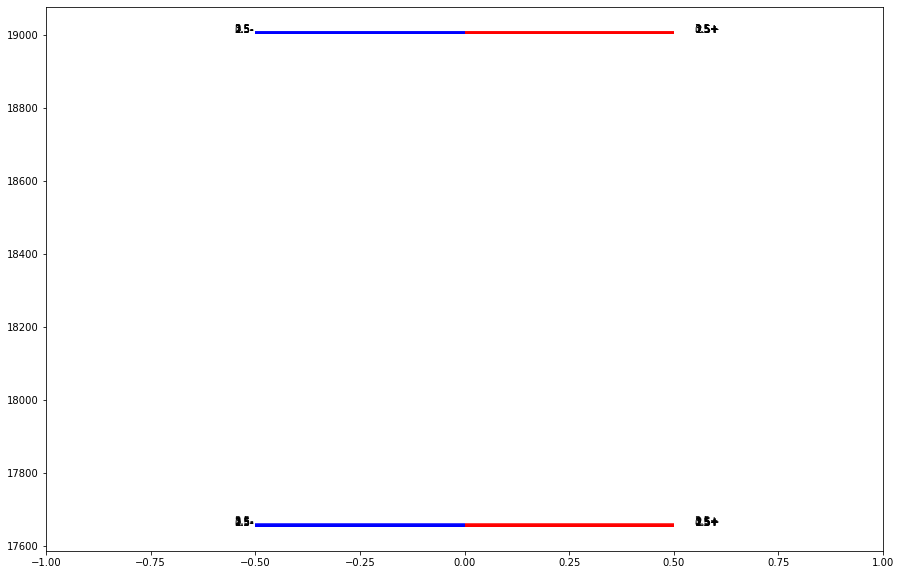

In [11]:
sub_B = False

params_A010 = params
plt.figure(figsize=(15,10))
for J in np.arange(1/2,4):
    Hp = A010(J,1,params_A010)
    Hm = A010(J,-1,params_A010)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    print((vals_p-vals_m)*29979.2458)
    _J = [J for val in vals_p]
    [plt.hlines(y=val,color='red',xmin=0.0,xmax=0.5) for val in vals_p]
    [plt.annotate(f'{J}+',(0.55,val)) for val in vals_p]
    [plt.hlines(y=val,color='blue',xmin=-0.5,xmax=-0.0) for val in vals_m]
    [plt.annotate(f'{J}-',(-0.55,val)) for val in vals_m]

# plt.ylim(33,40)
plt.xlim(-1,1)

In [13]:
def sig0_resid(params,data_p,data_m,Jmax=1/2,uncertainty=0.001, no_uncert=False):
    theory_p = []
    theory_m = []
    for J in np.arange(1/2,Jmax+1):
        HJp = A010(J,1,params)
        HJm = A010(J,-1,params)
        vals_p,vecs_p = np.linalg.eigh(HJp)
        vals_m,vecs_m = np.linalg.eigh(HJm)
        if J==1/2:
            theory_p=vals_p.min()
            theory_m=vals_m.min()
        else:
            theory_p.append(sorted(vals_p)[0])
            theory_p.append(sorted(vals_p)[1])
            theory_m.append(sorted(vals_m)[0])
            theory_m.append(sorted(vals_m)[1])
    all_data  = np.array([data_p,data_m])
#     all_data-=all_data.min()
    all_theory = np.array([theory_p,theory_m])
#     all_theory-=all_theory.min()
    if no_uncert:
        uncertainty=1
    resid = (all_data - all_theory)/uncertainty
    return resid

def A010_resid(params,data_p,data_m,Jmax=5/2,uncertainty = 0.001,no_uncert = False):
    theory_p = []
    theory_m = []
    for J in np.arange(1/2,Jmax+1):
        HJp = A010(J,1,params)
        HJm = A010(J,-1,params)
        vals_p,vecs_p = np.linalg.eigh(HJp)
        vals_m,vecs_m = np.linalg.eigh(HJm)
        if J==1/2:
            theory_p.append(vals_p.min())
            theory_m.append(vals_m.min())
        else:
            theory_p.append(sorted(vals_p)[0])
            theory_p.append(sorted(vals_p)[1])
            theory_m.append(sorted(vals_m)[0])
            theory_m.append(sorted(vals_m)[1])
    all_data  = np.concatenate((data_p,data_m))
#     all_data-= all_data[0]
    all_theory = np.concatenate((theory_p,theory_m))
#     all_theory-=all_theory[0]
    if no_uncert:
        uncertainty=1
    resid = (all_data - all_theory)/uncertainty
    return resid

In [14]:
data_p = [17651.4518,17651.8628,17652.6353,17652.8624,17654.1210]
data_m = [17651.4685,17651.8466,17652.6182,17652.8845,17654.1462]

In [15]:
%matplotlib inline

In [79]:
params = Parameters()
params.add('w2', value=328,min=320,max=340,vary=True)
params.add('A', value=1350,vary=False)
params.add('D',value=0,vary=False)
params.add('eDw2',value=0,vary=False)
params.add('B', value=0.253,min=0.23,max=0.27,vary=True)
params.add('pe',value=-0.4378,min=-5,max=5,vary=False)
params.add('qe',value=0.00,min=-0.1,max=0.1,vary=False)
params.add('pv',value=-0.4378,min=-5,max=5,vary=True)
params.add('qv',value=0,min=-0.1,max=0.1,vary=False)
params.add('gK',value=0.2458,min=-5,max=5,vary=True)
params.add('gamma',0.0,min=-5,max=5, vary=False)
# params.add('e',-0.1,min=-0.5,max=-0.01, vary=True)
params.add('e',-0.05,min=-0.5,max=-0.001, vary=True)
# params.add('ew2',-30,min=-50,max=-1, vary=True)
params.add('T0',17998.5875,min=0,max=18010, vary=False)

In [80]:
%matplotlib inline

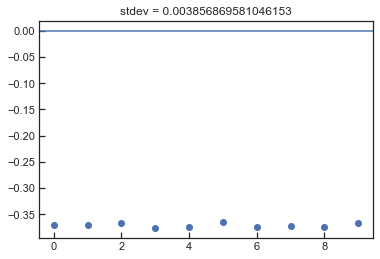

In [81]:
initial_resid = A010_resid(params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(initial_resid, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(initial_resid.std()))
plt.show()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
A          1350     -inf      inf     None    False     None     None
B        0.2526     0.23     0.27     None     True     None     None
D             0     -inf      inf     None    False     None     None
T0      1.8e+04        0 1.801e+04     None    False     None     None
e      -0.06571     -0.5   -0.001     None     True     None     None
eDw2          0     -inf      inf     None    False     None     None
gK       0.2193       -5        5     None     True     None     None
gamma         0       -5        5     None    False     None     None
pe      -0.4378       -5        5     None    False     None     None
pv      -0.4588       -5        5     None     True     None     None
qe            0     -0.1      0.1     None    False     None     None
qv            0     -0.1      0.1     None    False     None     None
w2        327.8      320      340     None     True     None     None


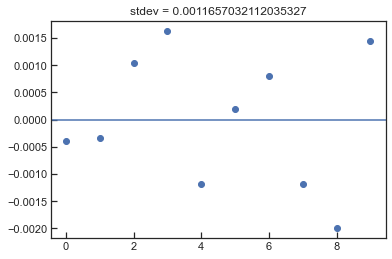

In [82]:
out = minimize(A010_resid, params, args=([data_p,data_m]),method='nelder')#,kws={'flist':True})#,method='least_squares')
out.params.pretty_print()
final_resid = A010_resid(out.params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(final_resid, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(final_resid.std()))
plt.show()

In [83]:
# Hm[0,1]**2/(1350) - Hp[0,1]**2/(1350)

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
A          1350     -inf      inf        0    False     None     None
B        0.2526     0.23     0.27 0.0002332     True     None     None
D             0     -inf      inf        0    False     None     None
T0      1.8e+04        0 1.801e+04        0    False     None     None
e      -0.06571     -0.5   -0.001 0.003471     True     None     None
eDw2          0     -inf      inf        0    False     None     None
gK       0.2193       -5        5 0.006105     True     None     None
gamma         0       -5        5        0    False     None     None
pe      -0.4378       -5        5        0    False     None     None
pv      -0.4588       -5        5  0.04003     True     None     None
qe            0     -0.1      0.1        0    False     None     None
qv            0     -0.1      0.1        0    False     None     None
w2        327.8      320      340  0.04857     True     None     None


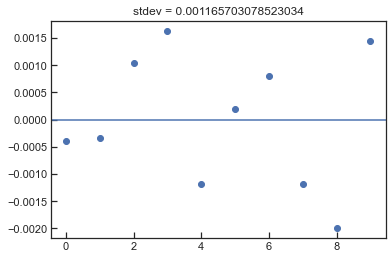

In [84]:
mini = lmfit.Minimizer(A010_resid, out.params, fcn_args=([data_p,data_m]))
out2 = mini.minimize(method='least_squares')#,kws={'flist':True})#,method='least_squares')
out2.params.pretty_print()
final_resid2 = A010_resid(out2.params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(final_resid2, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(final_resid2.std()))
plt.show()
out2

In [114]:
0.04*2

0.08

In [85]:
ci, trace = lmfit.conf_interval(mini, out2, sigmas=[1, 2,3], trace=True)
lmfit.printfuncs.report_ci(ci)

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 w2:  -0.22646  -0.11643  -0.05636 327.82629  +0.05813  +0.13928  +0.30756
 B :  -0.00128  -0.00062  -0.00026   0.25265  +0.00026  +0.00062  +0.00128
 pv:  -0.27508  -0.11599  -0.04585  -0.45882  +0.04282  +0.09786  +0.19083
 gK:  -0.03803  -0.01719  -0.00696   0.21933  +0.00661  +0.01520  +0.02944
 e :  -0.01909  -0.00918  -0.00385  -0.06571  +0.00385  +0.00917  +0.01906


In [96]:
ngrid = 39
getlim = lambda x,nstd: (out2.params[x].value+out2.params[x].stderr*nstd,out2.params[x].value-out2.params[x].stderr*nstd)
c_info = [
    lmfit.conf_interval2d(mini, out2, 'gK', 'e', ngrid, ngrid,limits=(getlim('gK',5),getlim('e',5))),
#     lmfit.conf_interval2d(mini, out2, 'gamma', 'e', 30, 30),
    lmfit.conf_interval2d(mini, out2, 'w2', 'e', ngrid, ngrid,limits=(getlim('w2',5),getlim('e',5))),
#     lmfit.conf_interval2d(mini, out2, 'gK', 'gamma', 30, 30),
    lmfit.conf_interval2d(mini, out2, 'e', 'pv', ngrid, ngrid,limits=(getlim('e',5),getlim('pv',5))),
    lmfit.conf_interval2d(mini, out2, 'gK', 'pv', ngrid, ngrid,limits=(getlim('gK',5),getlim('pv',5))),
    lmfit.conf_interval2d(mini, out2, 'gK', 'w2', ngrid, ngrid,limits=(getlim('gK',5),getlim('w2',5))),
    lmfit.conf_interval2d(mini, out2, 'pv', 'w2', ngrid, ngrid,limits=(getlim('pv',5),getlim('w2',5))),
#     lmfit.conf_interval2d(mini, out2, 'w2', 'gamma', 30, 30)
]

In [97]:
xy_labels = [
    ['$g_K$','$\\epsilon$'],
#     ['$\\gamma$','$\\epsilon$'],
    ['$\\omega_2$','$\\epsilon$'],
    ['$\\epsilon$','$p_G$'],
    ['$g_K$','$p_G$'],
    #     ['$g_K$','$\\gamma$'],
    ['$g_K$','$\\omega_2$'],
    ['$p_G$','$\\omega_2$']
]

In [98]:
plt.rcParams.update({'font.size': 10})
save=r'C:\Users\Arian\Dropbox (Hutzler Lab)\HutzlerLabShared\Personal\ArianJadbabaie\Thesis\Ch4\\'
import seaborn as sns
sns.set()
sns.set_style('ticks')
sns.set_style({'ytick.direction':'in','xtick.direction':'in'})

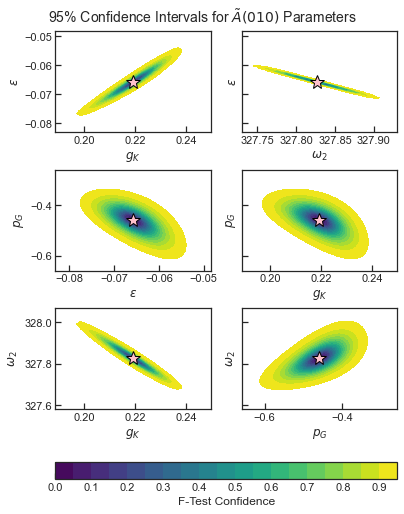

In [109]:
# plot confidence intervals
fig, axes = plt.subplots(3, 2, figsize=(5.5, 7),constrained_layout=True,sharey='row')
plt.suptitle('95% Confidence Intervals for $\\tilde{A}(010)$ Parameters',fontsize=14)
axes = axes.flatten()

for i,ax in enumerate(axes):
#     if i==3:
# #         ax.axis('off')
#         pass
#     else:
    cx,cy,grid = c_info[i]
    ctp = ax.contourf(cx, cy, grid,np.linspace(0, 0.95, 20),cmap='viridis')
    ax.set_xlabel(xy_labels[i][0])
    ax.set_ylabel(xy_labels[i][1])
    if i==0:
        ax.plot([out2.params['gK'].value],[out2.params['e'].value],marker='*',markersize=15,mfc='pink',mew=1,color='black')
    if i==1:
        ax.plot([out2.params['w2'].value],[out2.params['e'].value],marker='*',markersize=15,mfc='pink',mew=1,color='black')
        ax.set_xlim(327.73,327.93)
    if i==2:
        ax.plot([out2.params['e'].value],[out2.params['pv'].value],marker='*',markersize=15,mfc='pink',mew=1,color='black')
    if i==3:
        ax.plot([out2.params['gK'].value],[out2.params['pv'].value],marker='*',markersize=15,mfc='pink',mew=1,color='black')
    if i==4:
        ax.plot([out2.params['gK'].value],[out2.params['w2'].value],marker='*',markersize=15,mfc='pink',mew=1,color='black')
    if i==5:
        ax.plot([out2.params['pv'].value],[out2.params['w2'].value],marker='*',markersize=15,mfc='pink',mew=1,color='black')

#         ax.tick_params(axis='both')
#         if i in [0,1]:
#             ax.set_ylim(-0.078,-0.058)
#         if i==0:
#     # #             ax.set_xlim(0.195,0.235)
#             ax.plot([out2.params['gK'].value],[out2.params['e'].value],marker='*',markersize=15,mfc='pink',mew=1,color='blue')
#         if i==1:
#     # #             ax.set_xlim(327.65,328)
#             ax.plot([out2.params['w2'].value],[out2.params['e'].value],marker='*',markersize=15,mfc='pink',mew=1,color='blue')
#         if i ==2:
#             ax.plot([out2.params['gK'].value],[out2.params['w2'].value],marker='*',markersize=15,mfc='pink',mew=1,color='blue')
#             ax.set_xlim(0.195,0.235)
#             ax.set_ylim(0.2521,0.2531)
cbar = fig.colorbar(ctp,ax=axes.tolist(),location='bottom')
cbar.set_label('F-Test Confidence', rotation=0)
plt.savefig(save+'A010_95p_e_gk_pG_w2.pdf',format='pdf')
plt.savefig(save+'A010_95p_e_gk_pG_w2.svg',format='svg')

In [374]:
c_info[1]

(array([327.72552086, 327.73074343, 327.735966  , 327.74118856,
        327.74641113, 327.7516337 , 327.75685627, 327.76207884,
        327.76730141, 327.77252397, 327.77774654, 327.78296911,
        327.78819168, 327.79341425, 327.79863682, 327.80385938,
        327.80908195, 327.81430452, 327.81952709, 327.82474966,
        327.82997223, 327.83519479, 327.84041736, 327.84563993,
        327.8508625 , 327.85608507, 327.86130764, 327.8665302 ,
        327.87175277, 327.87697534, 327.88219791, 327.88742048,
        327.89264304, 327.89786561, 327.90308818, 327.90831075,
        327.91353332, 327.91875589, 327.92397845, 327.92920102]),
 array([-0.07160547, -0.07130722, -0.07100897, -0.07071072, -0.07041247,
        -0.07011422, -0.06981597, -0.06951772, -0.06921947, -0.06892122,
        -0.06862297, -0.06832472, -0.06802647, -0.06772822, -0.06742997,
        -0.06713172, -0.06683347, -0.06653521, -0.06623696, -0.06593871,
        -0.06564046, -0.06534221, -0.06504396, -0.06474571, -0.064

In [48]:
params = Parameters()
params.add('w2', value=out2.params['w2'].value,min=320,max=340,vary=False)
params.add('A', value=1350,vary=False)
params.add('D',value=0,vary=False)
params.add('eDw2',value=0,vary=False)
params.add('B', value=out2.params['B'].value,min=0.23,max=0.27,vary=True)
params.add('pe',value=-0.4378,min=-5,max=5,vary=False)
# params.add('qe',value=0.001,min=-0.1,max=0.1,vary=True)
params.add('pv',value=-0.4378,min=-5,max=5,vary=False)
# params.add('qv',value=-0.001,min=-0.1,max=0.1,vary=True)
params.add('gK',value=out2.params['gK'].value,min=-5,max=5,vary=True)
params.add('gamma',out2.params['gamma'].value,min=-5,max=5, vary=False)
params.add('e',out2.params['e'].value,min=-0.5,max=-0.001, vary=True)
# params.add('ew2',out2.params['e'].value*out2.params['w2'].value,min=-50,max=-1, vary=True)
params.add('T0',17998.5875,min=0,max=18010, vary=False)

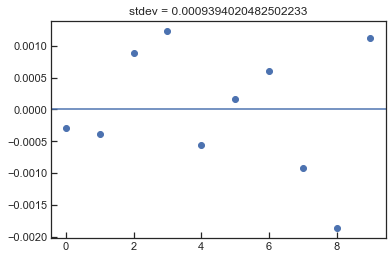

In [49]:
initial_resid = A010_resid(params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(initial_resid, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(initial_resid.std()))
plt.show()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
A          1350     -inf      inf     None    False     None     None
B        0.2526     0.23     0.27     None     True     None     None
D             0     -inf      inf     None    False     None     None
T0      1.8e+04        0 1.801e+04     None    False     None     None
e      -0.06629     -0.5   -0.001     None     True     None     None
eDw2          0     -inf      inf     None    False     None     None
gK       0.2184       -5        5     None     True     None     None
gamma         0       -5        5     None    False     None     None
pe      -0.4378       -5        5     None    False     None     None
pv      -0.4378       -5        5     None    False     None     None
w2        327.8      320      340     None    False     None     None


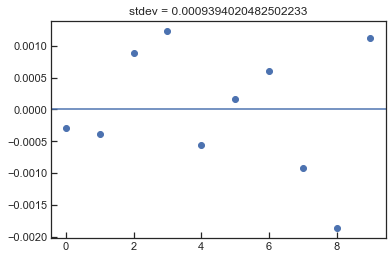

In [50]:
out3 = minimize(A010_resid, params, args=([data_p,data_m]),method='nelder')#,kws={'flist':True})#,method='least_squares')
out3.params.pretty_print()
final_resid3 = A010_resid(out3.params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(final_resid3, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(final_resid3.std()))
plt.show()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
A          1350     -inf      inf        0    False     None     None
B        0.2526     0.23     0.27 0.0001579     True     None     None
D             0     -inf      inf        0    False     None     None
T0      1.8e+04        0 1.801e+04        0    False     None     None
e      -0.06629     -0.5   -0.001 6.059e-05     True     None     None
eDw2          0     -inf      inf        0    False     None     None
gK       0.2184       -5        5 0.001085     True     None     None
gamma         0       -5        5        0    False     None     None
pe      -0.4378       -5        5        0    False     None     None
pv      -0.4378       -5        5        0    False     None     None
w2        327.8      320      340        0    False     None     None


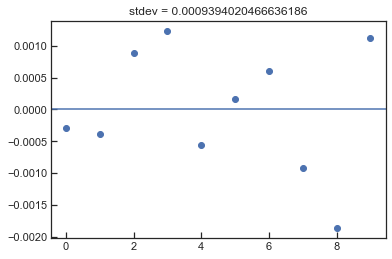

In [51]:
mini = lmfit.Minimizer(A010_resid, out3.params, fcn_args=([data_p,data_m]))
out4 = mini.minimize(method='least_squares')#,kws={'flist':True})#,method='least_squares')
out4.params.pretty_print()
final_resid4 = A010_resid(out4.params,data_p,data_m,no_uncert=True)
plt.figure()
plt.plot(final_resid4, 'bo')
plt.axhline(y=0)
plt.title('stdev = '+ str(final_resid4.std()))
plt.show()
out4

In [188]:
0.00006*2

0.00012

In [187]:
0.00108*2

0.00216

In [52]:
c_info2 = [
    lmfit.conf_interval2d(mini, out4, 'gK', 'e', 30, 30),
    lmfit.conf_interval2d(mini, out4, 'B', 'e', 30, 30),
    lmfit.conf_interval2d(mini, out2, 'gK', 'B', 30, 30),
]

In [80]:
xy_labels2 = [
    ['$g_K$ (cm$^{-1}$)','$\\epsilon$'],
    ['$B$ (cm$^{-1}$)','$\\epsilon$'],
    ['$g_K$ (cm$^{-1}$)','$B$ (cm$^{-1}$)'],
]

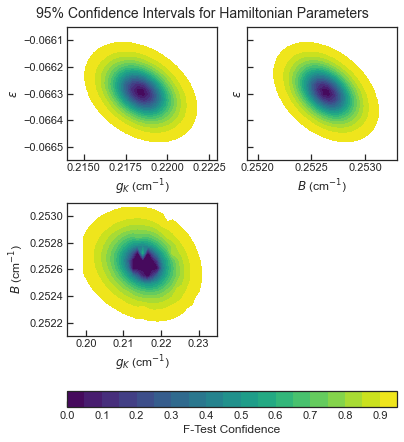

In [170]:
# plot confidence intervals
fig, axes = plt.subplots(2, 2, figsize=(5.5,6),constrained_layout=True,sharey='row')
plt.suptitle('95% Confidence Intervals for Hamiltonian Parameters',fontsize=14)
axes = axes.flatten()

for i,ax in enumerate(axes):
    if i==3:
        ax.axis('off')
    else:
        cx,cy,grid = c_info2[i]
        ctp = ax.contourf(cx, cy, grid,np.linspace(0, 0.95, 20),cmap='viridis')
        ax.set_xlabel(xy_labels2[i][0])
        ax.set_ylabel(xy_labels2[i][1])
        ax.tick_params(axis='both')
        if i in [0,1]:
            ax.set_ylim(-0.06655,-0.06605)
        if i==0:
            ax.set_xlim(0.214,0.223)
        if i==1:
            ax.set_xlim(0.2519,0.2533)
        if i ==2:
            ax.set_xlim(0.195,0.235)
            ax.set_ylim(0.2521,0.2531)
cbar = fig.colorbar(ctp,ax=axes.tolist(),location='bottom')
cbar.set_label('F-Test Confidence', rotation=0)
# fig.execute_constrained_layout()
# box = axes[2].get_position()
# box.x0 = box.x0 + 0.23
# box.x1 = box.x1 + 0.23
# box.y0 = box.y0 - 0.035
# box.y1 = box.y1 - 0.035
# axes[2].set_position(box)
# fig.execute_constrained_layout()

# cbar.ax.tick_params() 
plt.savefig(save+'A010_95p_e_gk_B.pdf',format='pdf')
plt.savefig(save+'A010_95p_e_gk_B.svg',format='svg')

In [117]:
sns.set_style({"axes.spines.bottom":False,'axes.spines.top':False,'axes.spines.right':False,'ytick.left':True,'ytick.direction':'out'})

Text(0.5, 1.0, '$\\tilde{A}(010)$ Levels')

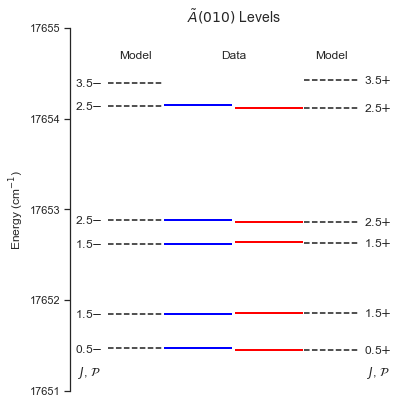

In [121]:
from matplotlib.ticker import StrMethodFormatter
sub_B = False
fitparams = out2.params
fig = plt.figure(figsize=(5.5,5.5),constrained_layout=True)
depert = False
off=[]
for J in np.arange(1/2,5):
    Hp = A010(J,1,fitparams,depert=depert)
    Hm = A010(J,-1,fitparams,depert=depert)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    if J==1/2:
        off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
        off = [0,0]
#     print((vals_p-vals_m)*29979.2458)
    [plt.hlines(y=val+off[0],color='red',xmin=0.005,xmax=0.255,linewidth=1.5) for val in data_p]
    [plt.hlines(y=val+off[1],color='blue',xmin=-0.255,xmax=-0.005,linewidth=1.5) for val in data_m]
    [plt.hlines(y=_p,color='k',linestyle='--',xmin=0.26,xmax=0.46,linewidth=1.5) for _p in vals_p]
    [plt.hlines(y=_m,color='k',linestyle='--',xmin=-0.46,xmax=-0.26,linewidth=1.5) for _m in vals_m]
    [plt.annotate(f'{J}$+$',(0.53,val+off[0]),verticalalignment='center',horizontalalignment='center') for val in vals_p]
    [plt.annotate(f'{J}$-$',(-0.53,val+off[1]),verticalalignment='center',horizontalalignment='center') for val in vals_m]
# sns.despine()
plt.xticks([])
plt.annotate(r'$J$, $\mathcal{P}$',(-0.53,17651.2),verticalalignment='center',horizontalalignment='center')
plt.annotate(r'$J$, $\mathcal{P}$',(0.53,17651.2),verticalalignment='center',horizontalalignment='center')
plt.yticks([17651,17652,17653,17654,17655])
plt.annotate('Data',(0,17654.7),verticalalignment='center',horizontalalignment='center')
plt.annotate('Model',(-0.36,17654.7),verticalalignment='center',horizontalalignment='center')
plt.annotate('Model',(0.36,17654.7),verticalalignment='center',horizontalalignment='center')
plt.ylim(17651,17655)
# plt.ylim(17651.5,17653)
plt.xlim(-0.6,0.6)
plt.ylabel('Energy (cm$^{-1}$)')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title(r'$\tilde{A}(010)$ Levels',fontsize=14)

In [122]:
fig.savefig(save+'A010_levels_fit.pdf')
fig.savefig(save+'A010_levels_fit.svg')

Text(0.5, 1.02, '$\\tilde{A}(010)$ Deperturbation')

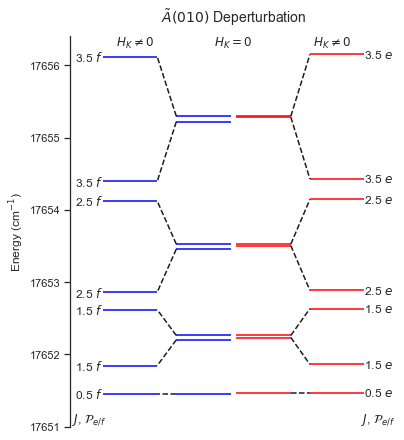

In [119]:
sub_B = False
fitparams = out2.params
fig=plt.figure(figsize=(5.5,6),constrained_layout=True)
elevels = []
flevels = []
for J in np.arange(1/2,15):
    nolL = copy.deepcopy(fitparams)
    nolL['pe'].value = 0
    nolL['pv'].value = 0
    Hp = A010(J,1,nolL)
    Hm = A010(J,-1,nolL)
    valsd_p,vecs_p = np.linalg.eigh(Hp)
    valsd_m,vecs_m = np.linalg.eigh(Hm)
    if (-1)**(J-1/2-1)<0:
        e_par = valsd_m
        f_par = valsd_p
    else:
        e_par = valsd_p
        f_par = valsd_m
    valsd_p = e_par
    valsd_m = f_par
    valsd_p-=sub_B*nolL['B']*J*(J+1)
    valsd_m-=sub_B*nolL['B']*J*(J+1)
#     if J==1/2:
#         off = [min(data_p)-min(valsd_p),min(data_m)-min(valsd_m)]
#     print((vals_p-vals_m)*29979.2458)
    ept = 0.2
    off = 0.01
    sep = 0.07
    [plt.hlines(y=val,color='red',linestyle='-',xmin=off,xmax=ept+off) for val in valsd_p]
    [plt.hlines(y=val,color='blue',linestyle='-',xmin=-ept-off,xmax=-off) for val in valsd_m]
    
    all_int = copy.deepcopy(fitparams)
    Hp = A010(J,1,all_int)
    Hm = A010(J,-1,all_int)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    if (-1)**(J-1/2-1)<0:
        e_par = vals_m
        f_par = vals_p
    else:
        e_par = vals_p
        f_par = vals_m
    vals_p = e_par
    vals_m = f_par
    vals_p-=sub_B*all_int['B']*J*(J+1)
    vals_m-=sub_B*all_int['B']*J*(J+1)
    [plt.hlines(y=_p,color='red',xmin=ept+off+sep,xmax=2*ept+off+sep) for _p in vals_p]
    [plt.hlines(y=_m,color='blue',xmin=-off-2*ept-sep,xmax=-off-ept-sep) for _m in vals_m]

    m_slope = [(vm - dm)/(-sep) for (vm,dm) in zip(vals_m, valsd_m)]
    p_slope = [(vp - dp)/(sep) for (vp,dp) in zip(vals_p, valsd_p)]
    
    xp = np.linspace(ept+off,ept+off+sep)
    xm = np.linspace(-(ept+off),-(ept+off+sep))
    [plt.plot(xp,ps*(xp-(ept+off))+dp,'k',linestyle='--') for (ps,dp) in zip(p_slope, valsd_p)]
    [plt.plot(xm,ms*(xm+((ept+off)))+dm,'k',linestyle='--') for (ms,dm) in zip(m_slope, valsd_m)]

    [plt.annotate(f'{J} $e$',(2*ept+off+sep+0.05,val),verticalalignment='center',horizontalalignment='center') for val in vals_p]
    [plt.annotate(f'{J} $f$',(-(2*ept+off+sep+0.05),val),verticalalignment='center',horizontalalignment='center') for val in vals_m]
    
    [elevels.append(elev) for elev in vals_p[vals_p<19000]]
    [flevels.append(flev) for flev in vals_m[vals_m<19000]]

plt.xticks([])
plt.ylim(17651,17656.4)
plt.xlim(-0.6,0.6)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.annotate('$H_K=0$',(0,17656.3),verticalalignment='center',horizontalalignment='center')
plt.annotate('$H_K\\neq 0$',(-0.36,17656.3),verticalalignment='center',horizontalalignment='center')
plt.annotate('$H_K\\neq 0$',(0.36,17656.3),verticalalignment='center',horizontalalignment='center')
plt.annotate(r'$J$, $\mathcal{P}_{e/f}$',(-0.53,17651.1),verticalalignment='center',horizontalalignment='center')
plt.annotate(r'$J$, $\mathcal{P}_{e/f}$',(0.53,17651.1),verticalalignment='center',horizontalalignment='center')
plt.ylabel('Energy (cm$^{-1}$)')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title(r'$\tilde{A}(010)$ Deperturbation',y=1.02,fontsize=14)

In [120]:
fig.savefig(save+'A010_depert_levels.pdf')
fig.savefig(save+'A010_depert_levels.svg')

In [163]:
box1 = axes[1].get_position()
box2 = axes[1].get_position()

In [164]:
box1.y1 - box1.y0

0.34807097025462963

In [165]:
box2.y1 - box2.y0

0.34807097025462963

In [155]:
box

Bbox([[0.3887127272727273, 0.19672261111111072], [0.7680535129068454, 0.5043552870370349]])

In [1354]:
-0.06787818*327.875

-22.2555582675

In [1353]:
-0.06787818*327.875

0.018899370750000002

In [1]:
sub_B = False
fitparams = out2.params
plt.figure(figsize=(15,10))
depert = False
off=[]
for J in np.arange(1/2,16):
    Hp = A010(J,1,fitparams,depert=depert)
    Hm = A010(J,-1,fitparams,depert=depert)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    if J==1/2:
        off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
#     print((vals_p-vals_m)*29979.2458)
    [plt.hlines(y=val+off[0],color='red',xmin=0.0,xmax=0.5) for val in vals_p]
    [plt.annotate(f'{J}+',(0.55,val+off[0])) for val in vals_p]
    [plt.hlines(y=val+off[1],color='blue',xmin=-0.5,xmax=-0.0) for val in vals_m]
    [plt.hlines(y=_p,color='k',linestyle='--',xmin=0.0,xmax=0.5) for _p in data_p]
    [plt.hlines(y=_m,color='k',linestyle='--',xmin=-0.5,xmax=0.0) for _m in data_m]
    [plt.annotate(f'{J}-',(-0.55,val+off[1])) for val in vals_m]
sns.despine()
plt.ylim(17650,17655)
plt.xlim(-1,1)

NameError: name 'out2' is not defined

(-1.0, 1.0)

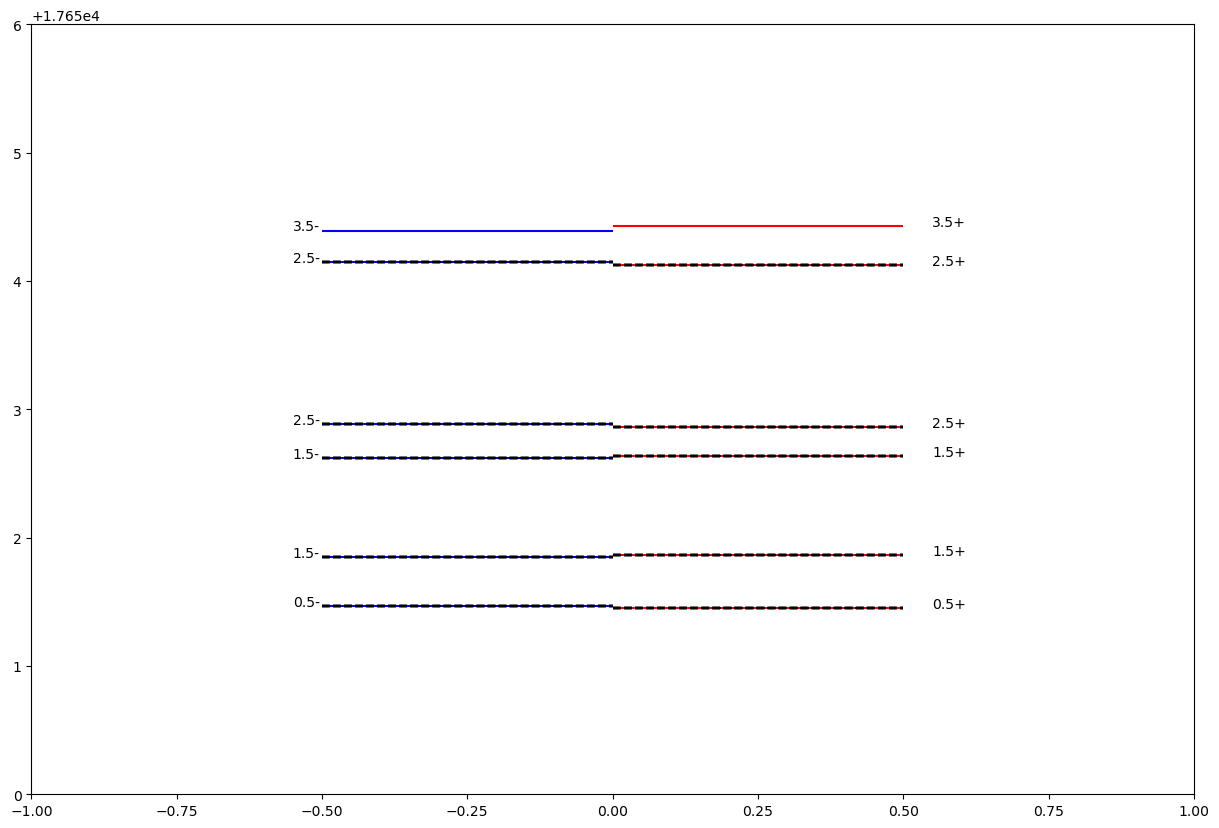

In [569]:
sub_B = False
fitparams = out2.params
plt.figure(figsize=(15,10))
depert = False
off=[]
for J in np.arange(1/2,16):
    Hp = A010(J,1,fitparams,depert=depert)
    Hm = A010(J,-1,fitparams,depert=depert)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    if J==1/2:
        off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
#     print((vals_p-vals_m)*29979.2458)
    [plt.hlines(y=val+off[0],color='red',xmin=0.0,xmax=0.5) for val in vals_p]
    [plt.annotate(f'{J}+',(0.55,val+off[0])) for val in vals_p]
    [plt.hlines(y=val+off[1],color='blue',xmin=-0.5,xmax=-0.0) for val in vals_m]
    [plt.hlines(y=_p,color='k',linestyle='--',xmin=0.0,xmax=0.5) for _p in data_p]
    [plt.hlines(y=_m,color='k',linestyle='--',xmin=-0.5,xmax=0.0) for _m in data_m]
    [plt.annotate(f'{J}-',(-0.55,val+off[1])) for val in vals_m]

plt.ylim(17650,17656)
plt.xlim(-1,1)

In [1313]:
J=1/2
Hp = A010(J,1,fitparams,depert=False)
Hm = A010(J,-1,fitparams,depert=False)
vals_p,vecs_p = np.linalg.eigh(Hp)
vals_m,vecs_m = np.linalg.eigh(Hm)

In [1314]:
vals_p

array([17651.45208906, 19002.62484411])

In [1316]:
Hp

array([[19002.26741973,   -21.97303661],
       [  -21.97303661, 17651.80951345]])

In [1317]:
Hm

array([[19002.26741973,    21.46776231],
       [   21.46776231, 17651.80951345]])

In [1315]:
np.round(vecs_p.T,4)

array([[-0.0163, -0.9999],
       [-0.9999,  0.0163]])

In [582]:
vals_m

array([17651.84599521, 17652.61911553, 19003.39112243])

In [583]:
np.round(vecs_m.T,4)

array([[-6.783e-01, -1.230e-02, -7.347e-01],
       [-7.348e-01,  1.100e-02,  6.782e-01],
       [ 3.000e-04, -9.999e-01,  1.650e-02]])

In [465]:
vecs_m.T

array([[ 2.82515028e-04,  7.01184731e-01,  1.16697268e-02,
        -7.12884080e-01],
       [ 2.87814067e-04,  7.12979388e-01, -1.08434239e-02,
         7.01101084e-01],
       [-9.99999624e-01,  4.02953728e-04,  7.68329820e-04,
         1.26195533e-05],
       [ 7.68251257e-04, -4.51863531e-04,  9.99872816e-01,
         1.59235142e-02]])

In [466]:
vecs_p.T[0]@Hp@vecs_p.T[0]

17652.861118990033

(-0.6, 0.6)

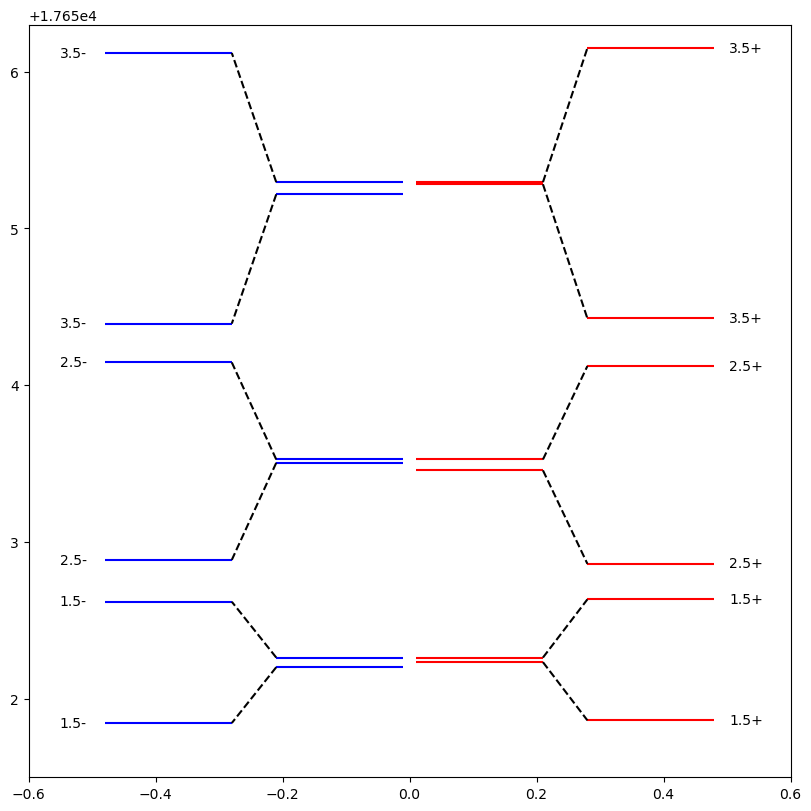

In [1413]:
sub_B = False
fitparams = out4.params
plt.figure(figsize=(8,8),constrained_layout=True)
depert = True
plevels = []
mlevels = []
for J in np.arange(1/2,15):
    Hp = A010(J,1,fitparams,depert=depert)
    Hm = A010(J,-1,fitparams,depert=depert)
    valsd_p,vecs_p = np.linalg.eigh(Hp)
    valsd_m,vecs_m = np.linalg.eigh(Hm)
    valsd_p-=sub_B*fitparams['B']*J*(J+1)
    valsd_m-=sub_B*fitparams['B']*J*(J+1)
#     if J==1/2:
#         off = [min(data_p)-min(valsd_p),min(data_m)-min(valsd_m)]
#     print((vals_p-vals_m)*29979.2458)
    ept = 0.2
    off = 0.01
    sep = 0.07
    [plt.hlines(y=val,color='r',linestyle='-',xmin=off,xmax=ept+off) for val in valsd_p]
    [plt.hlines(y=val,color='b',linestyle='-',xmin=-ept-off,xmax=-off) for val in valsd_m]

    Hp = A010(J,1,fitparams,depert=False)
    Hm = A010(J,-1,fitparams,depert=False)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    vals_p-=sub_B*fitparams['B']*J*(J+1)
    vals_m-=sub_B*fitparams['B']*J*(J+1)
    [plt.hlines(y=_p,color='red',xmin=ept+off+sep,xmax=2*ept+off+sep) for _p in vals_p]
    [plt.hlines(y=_m,color='blue',xmin=-off-2*ept-sep,xmax=-off-ept-sep) for _m in vals_m]
    [plt.annotate(f'{J}+',(2*ept+off+sep+0.05,val),verticalalignment='center',horizontalalignment='center') for val in vals_p]
    [plt.annotate(f'{J}-',(-(2*ept+off+sep+0.05),val),verticalalignment='center',horizontalalignment='center') for val in vals_m]

    m_slope = [(vm - dm)/(-sep) for (vm,dm) in zip(vals_m, valsd_m)]
    p_slope = [(vp - dp)/(sep) for (vp,dp) in zip(vals_p, valsd_p)]
    
    xp = np.linspace(ept+off,ept+off+sep)
    xm = np.linspace(-(ept+off),-(ept+off+sep))
    [plt.plot(xp,ps*(xp-(ept+off))+dp,'k',linestyle='--') for (ps,dp) in zip(p_slope, valsd_p)]
    [plt.plot(xm,ms*(xm+((ept+off)))+dm,'k',linestyle='--') for (ms,dm) in zip(m_slope, valsd_m)]
    
    [plevels.append(plev) for plev in vals_p[vals_p<19000]]
    [mlevels.append(mlev) for mlev in vals_m[vals_m<19000]]
    

plt.ylim(17651.5,17656.3)
plt.xlim(-0.6,0.6)

(-0.6, 0.6)

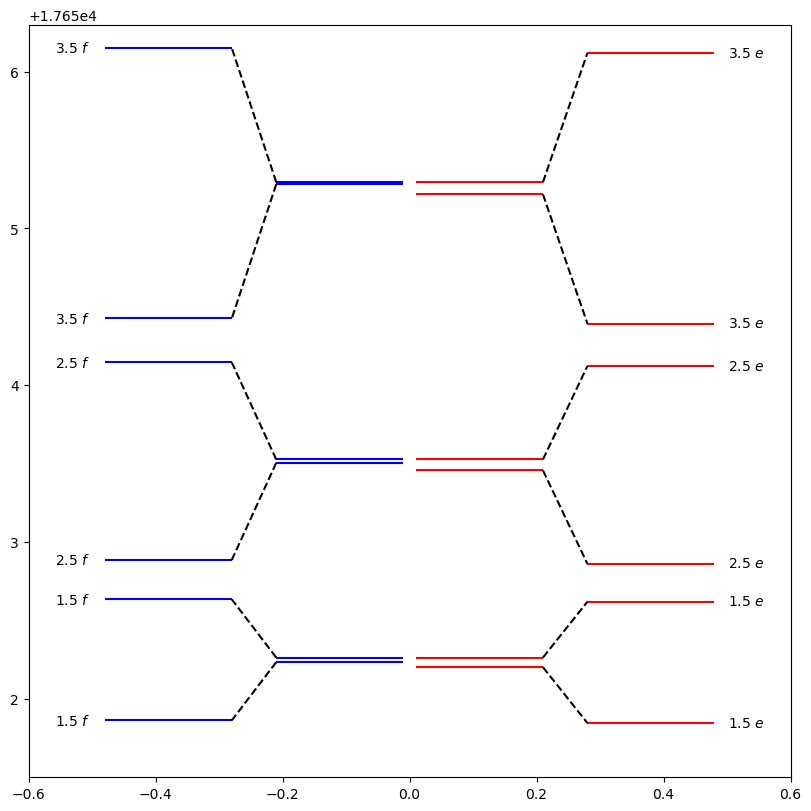

In [1412]:
sub_B = False
fitparams = out4.params
plt.figure(figsize=(8,8),constrained_layout=True)
elevels = []
flevels = []
for J in np.arange(1/2,15):
    nolL = copy.deepcopy(fitparams)
    nolL['pe'].value = 0
    nolL['pv'].value = 0
    Hp = A010(J,1,nolL)
    Hm = A010(J,-1,nolL)
    valsd_p,vecs_p = np.linalg.eigh(Hp)
    valsd_m,vecs_m = np.linalg.eigh(Hm)
    if (-1)**(J-1/2)<0:
        e_par = valsd_m
        f_par = valsd_p
    else:
        e_par = valsd_p
        f_par = valsd_m
    valsd_p = e_par
    valsd_m = f_par
    valsd_p-=sub_B*nolL['B']*J*(J+1)
    valsd_m-=sub_B*nolL['B']*J*(J+1)
#     if J==1/2:
#         off = [min(data_p)-min(valsd_p),min(data_m)-min(valsd_m)]
#     print((vals_p-vals_m)*29979.2458)
    ept = 0.2
    off = 0.01
    sep = 0.07
    [plt.hlines(y=val,color='r',linestyle='-',xmin=off,xmax=ept+off) for val in valsd_p]
    [plt.hlines(y=val,color='b',linestyle='-',xmin=-ept-off,xmax=-off) for val in valsd_m]
    
    all_int = copy.deepcopy(fitparams)
    Hp = A010(J,1,all_int)
    Hm = A010(J,-1,all_int)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    if (-1)**(J-1/2)<0:
        e_par = vals_m
        f_par = vals_p
    else:
        e_par = vals_p
        f_par = vals_m
    vals_p = e_par
    vals_m = f_par
    vals_p-=sub_B*all_int['B']*J*(J+1)
    vals_m-=sub_B*all_int['B']*J*(J+1)
    [plt.hlines(y=_p,color='red',xmin=ept+off+sep,xmax=2*ept+off+sep) for _p in vals_p]
    [plt.hlines(y=_m,color='blue',xmin=-off-2*ept-sep,xmax=-off-ept-sep) for _m in vals_m]

    m_slope = [(vm - dm)/(-sep) for (vm,dm) in zip(vals_m, valsd_m)]
    p_slope = [(vp - dp)/(sep) for (vp,dp) in zip(vals_p, valsd_p)]
    
    xp = np.linspace(ept+off,ept+off+sep)
    xm = np.linspace(-(ept+off),-(ept+off+sep))
    [plt.plot(xp,ps*(xp-(ept+off))+dp,'k',linestyle='--') for (ps,dp) in zip(p_slope, valsd_p)]
    [plt.plot(xm,ms*(xm+((ept+off)))+dm,'k',linestyle='--') for (ms,dm) in zip(m_slope, valsd_m)]

    [plt.annotate(f'{J} $e$',(2*ept+off+sep+0.05,val),verticalalignment='center',horizontalalignment='center') for val in vals_p]
    [plt.annotate(f'{J} $f$',(-(2*ept+off+sep+0.05),val),verticalalignment='center',horizontalalignment='center') for val in vals_m]
    
    [elevels.append(elev) for elev in vals_p[vals_p<19000]]
    [flevels.append(flev) for flev in vals_m[vals_m<19000]]
    
plt.ylim(17651.5,17656.3)
plt.xlim(-0.6,0.6)

In [494]:
flevels

[17651.46826104817,
 17651.862900969263,
 17652.634439727262,
 17652.88597660396,
 17654.145185898295,
 17654.425614461547,
 17656.14969044885,
 17656.47449423039,
 17658.655273453383,
 17659.03048726866,
 17661.664063316413,
 17662.092730248223,
 17665.17692312841,
 17665.660803719155,
 17669.194272101522,
 17669.734478609138,
 17673.716339070015,
 17674.31361900287,
 17678.743259710955,
 17679.39813908304,
 17684.275119603237,
 17684.987981969673,
 17690.31197538819,
 17691.083108463583,
 17696.853866026086,
 17697.683490671126,
 17703.900819171507,
 17704.789108204597,
 17711.452854972875]

In [495]:
plevels

[17651.45222258044,
 17651.862900969263,
 17652.634439727262,
 17652.861118990026,
 17654.121930000325,
 17654.425614461547,
 17656.14969044885,
 17656.433756525345,
 17658.61582827625,
 17659.03048726866,
 17661.664063316413,
 17662.03615420927,
 17665.121256371174,
 17665.660803719155,
 17669.194272101522,
 17669.662127006482,
 17673.644401201174,
 17674.31361900287,
 17678.743259710955,
 17679.31007986909,
 17684.18685969116,
 17684.987981969673,
 17690.31197538819,
 17690.97941243324,
 17696.749234078467,
 17697.683490671126,
 17703.900819171507,
 17704.669848403664,
 17711.331802528228]

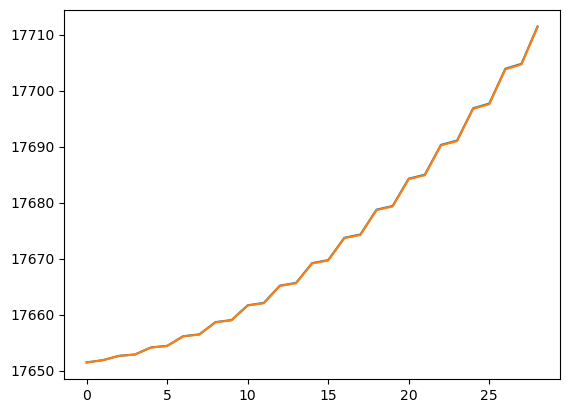

In [496]:
plt.plot(flevels)
plt.plot(elevels)

In [497]:
sr_e = []
sr_f = []
B_e = []
B_f = []
mean = []
for i in range(0,len(flevels),2):
    if i==len(flevels)-1:
        continue
    delta_e = abs(elevels[i+1]-elevels[i])
    delta_f = abs(flevels[i+1]-flevels[i])
    mean_e = (elevels[i+1]+elevels[i])/2
    mean_f = (flevels[i+1]+flevels[i])/2
    sr_e.append(delta_e)
    sr_f.append(delta_f)
    B_e.append(mean_e)
    B_f.append(mean_f)

In [498]:
from lmfit.models import QuadraticModel,LinearModel

In [499]:
qmodel = QuadraticModel(independent_vars=['x'])
pars = Parameters()
pars.add('a', value=0.25, min=0, max=1)
pars.add('b', expr='a')
pars.add('c',17651,min=17650,max=17654)

In [500]:
N = np.arange(1,len(B_f)+1,1)

In [501]:
resf = qmodel.fit(B_f,pars,x=N)
rese = qmodel.fit(B_e,pars,x=N)

In [502]:
resf

In [503]:
rese

In [504]:
pars = Parameters()
pars.add('frac_curve1', value=0.5, min=0, max=1)
pars.add('frac_curve2', expr='1-frac_curve1')

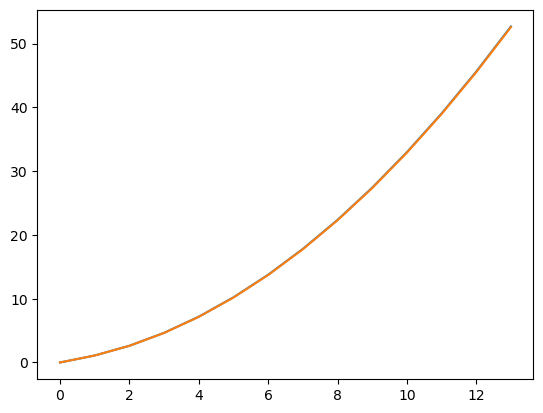

In [505]:
plt.plot(B_f-B_f[0])
plt.plot(B_e-B_e[0])

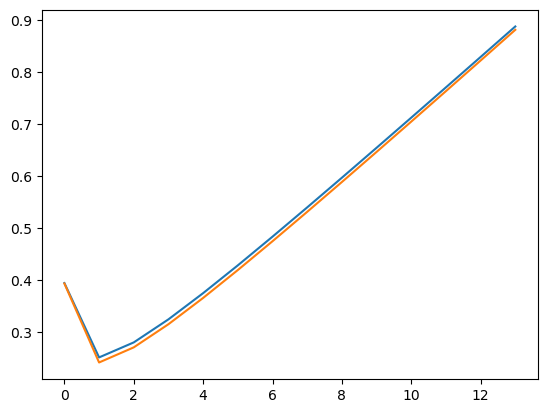

In [506]:
sr_e = np.array(sr_e)
sr_f = np.array(sr_f)
sr_mean = sr_e/2+sr_f/2
plt.plot(sr_f)
plt.plot(sr_e)

In [1374]:
qmodel = QuadraticModel(independent_vars=['x'])
pars = Parameters()
pars.add('a', value=0.01, min=0, max=1)
pars.add('b', value=0.1,vary=True)
pars.add('c',0.1,min=-1,max=1)

In [1391]:
Ni=1
Nf=10
resf = qmodel.fit(sr_f[Ni:Nf],pars,x=N[Ni:Nf])
rese = qmodel.fit(sr_e[Ni:Nf],pars,x=N[Ni:Nf])

In [1392]:
resf

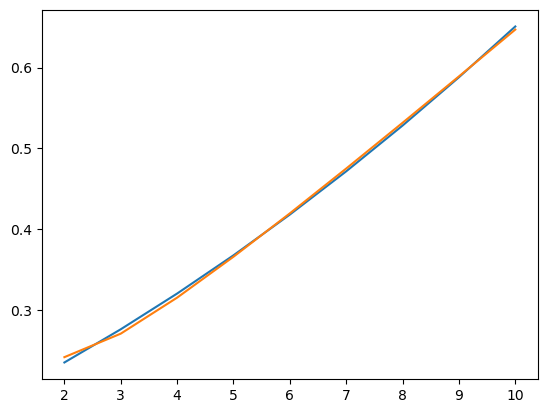

In [1393]:
plt.plot(N[Ni:Nf],qmodel.eval(rese.params,x=N[Ni:Nf]))
plt.plot(N[Ni:Nf],sr_e[Ni:Nf])

In [1394]:
rese

In [ ]:
plt.plot(qmodel())

In [1355]:
from lmfit import Model

def sr_splitting(N,g,l):
    return g/2*(1 - l**2/(N*(N+1)))*N + g/2*(1- l**2/(N*(N+1)))*(N+1)

srmodel = Model(sr_splitting)    

In [1356]:
parsf = Parameters()
parsf.add('g', value=0.05, min=0, max=10)
parsf.add('l',value=0,vary=False)
parse = Parameters()
parse.add('g', value=0.05, min=0, max=10)
parse.add('l',value=0,vary=False)


In [529]:
Ni=4
resf = srmodel.fit(sr_f[Ni:],parsf,N=N[Ni:])
rese = srmodel.fit(sr_e[Ni:],parse,N=N[Ni:])

In [530]:
resf

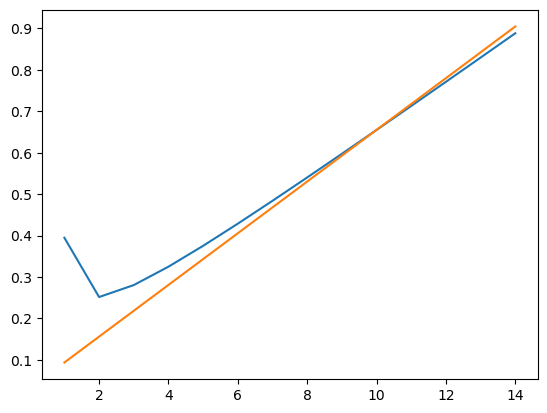

In [531]:
plt.plot(N,sr_f)
# plt.plot(N,sr_e)
plt.plot(N,sr_splitting(N,**resf.params))

In [1402]:
((sr_f+sr_e)[:3]/2).mean()

0.3055030348004948

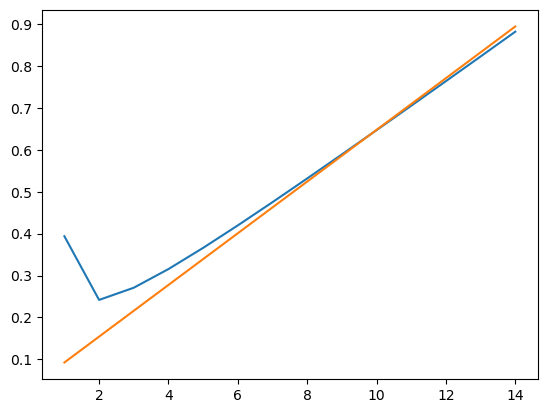

In [532]:
# plt.plot(N,sr_f)`
plt.plot(N,sr_e)
plt.plot(N,sr_splitting(N,**rese.params))

In [533]:
rese

In [534]:
print('sr mean',(rese.params['g'].value+resf.params['g'].value)/2)
print('sr diff',(rese.params['g'].value-resf.params['g'].value)/2)

sr mean 0.06203345403773236
sr diff -0.0003577403476542895


In [535]:
print('sr mean',29979.2458*(rese.params['g'].value+resf.params['g'].value)/2)
print('sr diff',29979.2458*(rese.params['g'].value-resf.params['g'].value)/2)

sr mean 1859.716166420181
sr diff -10.724785814905399


In [491]:
out2.params

name,value,standard error,relative error,initial value,min,max,vary
w2,327.875425,0.08460289,(0.03%),327.8753882662715,320.000000,340.000000,True
A,1350.00000,0.00000000,(0.00%),1350,-inf,inf,False
D,0.00000000,0.00000000,,0,-inf,inf,False
eDw2,0.00000000,0.00000000,,0,-inf,inf,False
B,0.25264138,1.8229e-04,(0.07%),0.25264126878244064,0.23000000,0.27000000,True
pe,-0.43780000,0.00000000,(0.00%),-0.4378,-5.00000000,5.00000000,False
pv,-0.43780000,0.00000000,(0.00%),-0.4378,-5.00000000,5.00000000,False
gK,0.21558554,0.00692838,(3.21%),0.21558758616701468,-5.00000000,5.00000000,True
gamma,0.01814449,0.03404243,(187.62%),0.018129271848437156,-5.00000000,5.00000000,True
e,-0.06788612,0.00377990,(5.57%),-0.0678844738969363,-0.50000000,-1.0000e-03,True


In [767]:
elevels = np.array(elevels)
flevels = np.array(flevels)

In [772]:
dparity = elevels - flevels

In [784]:
qeff = ((dparity[1:]+dparity[:1])/2)[::2]

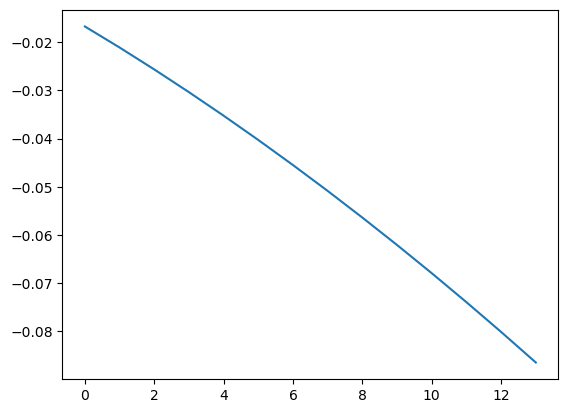

In [785]:
plt.plot(((dparity[1:]+dparity[:1])/2)[::2])

In [808]:
qmodel = QuadraticModel(independent_vars=['x'])
pars = Parameters()
pars.add('a', value=-0.02, min=-1, max=1)
pars.add('b', value=0,vary=True)
pars.add('c',0,vary=True)

In [809]:
res = qmodel.fit(qeff,pars,x=N)
res

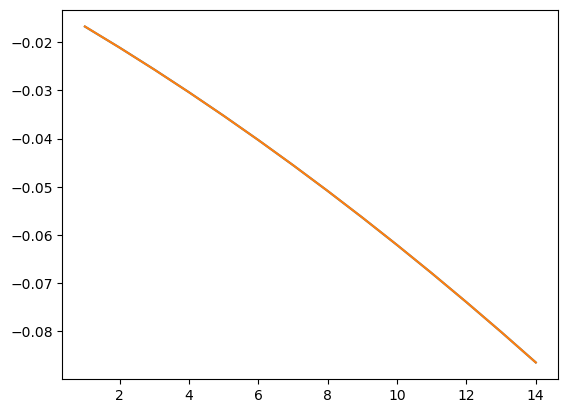

In [811]:
q = res.params['a']
q1 = res.params['b']
q0 = res.params['c']
plt.plot(N,qeff)
plt.plot(N,q*N**2+q1*N+q0)

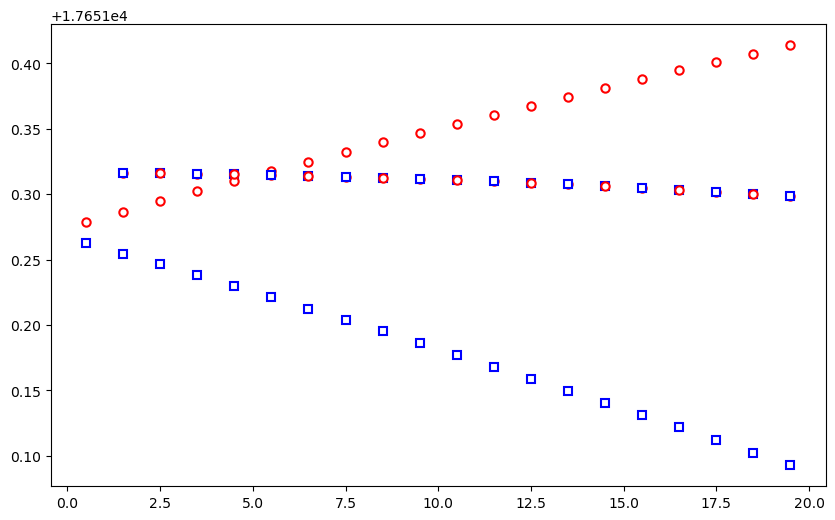

In [1408]:
subB = True
fitparams = out2.params
plt.figure(figsize=(10,6))
show_actual=False
off=[]
delta_on_e = []
delta_off_e = []
for J in np.arange(1/2,20.5):
    Hp = A010(J,1,fitparams,depert=True)
    Hm = A010(J,-1,fitparams,depert=True)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    vals_p = vals_p[vals_p<18000]
    vals_m = vals_m[vals_m<18000]
    if J==1/2:
        off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
#     print((vals_p-vals_m)*29979.2458)
    _J = np.array([J for i in vals_p])
    if (-1)**(J-1/2)<1:
        p_mark = 'ro'
        m_mark = 'bs'
    else:
        p_mark = 'bs'
        m_mark = 'ro'
    plt.plot(_J,vals_p-out2.params['B']*subB*_J*(_J+1),p_mark,mfc='white',mew=1.5)
    plt.plot(_J,vals_m-out2.params['B']*subB*_J*(_J+1),m_mark,mfc='white',mew=1.5)
    delta_off_e.append((vals_m.max()-vals_m.min())/2+(vals_p.max()-vals_p.min())/2)
    if show_actual:
        Hp = A010(J,1,fitparams,depert=False)
        Hm = A010(J,-1,fitparams,depert=False)
        vals_p,vecs_p = np.linalg.eigh(Hp)
        vals_m,vecs_m = np.linalg.eigh(Hm)
        vals_p = vals_p[vals_p<18000]
        vals_m = vals_m[vals_m<18000]
        if J==1/2:
            off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
        #     print((vals_p-vals_m)*29979.2458)
        _J = [J for i in vals_p]
        if (-1)**(J-1/2)<1:
            p_mark = 'ro'
            m_mark = 'bs'
        else:
            p_mark = 'bs'
            m_mark = 'ro'
        plt.plot(_J,vals_p-out2.params['B']*subB*J*(J+1),p_mark)
        plt.plot(_J,vals_m-out2.params['B']*subB*J*(J+1),m_mark)
        delta_on_e.append((vals_m.max()-vals_m.min())/2+(vals_p.max()-vals_p.min())/2)

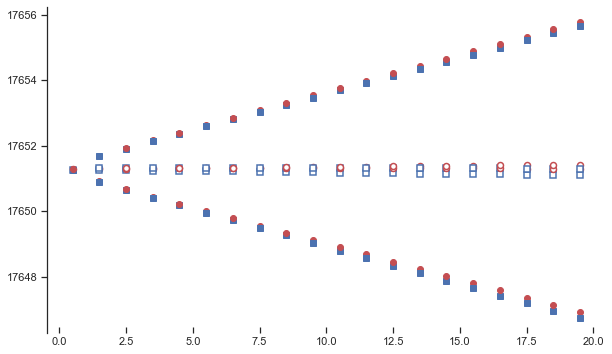

In [123]:
subB = True
fitparams = out2.params
plt.figure(figsize=(10,6))
show_actual=True
off=[]
delta_on_e = []
delta_off_e = []
for J in np.arange(1/2,20.5):
    Hp = A010(J,1,fitparams,depert=True)
    Hm = A010(J,-1,fitparams,depert=True)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    vals_p = vals_p[vals_p<18000]
    vals_m = vals_m[vals_m<18000]
    if J==1/2:
        off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
#     print((vals_p-vals_m)*29979.2458)
    _J = np.array([J for i in vals_p])
    if (-1)**(J-1/2)<1:
        p_mark = 'ro'
        m_mark = 'bs'
    else:
        p_mark = 'bs'
        m_mark = 'ro'
    plt.plot(_J,vals_p-out2.params['B']*subB*_J*(_J+1),p_mark,mfc='white',mew=1.5)
    plt.plot(_J,vals_m-out2.params['B']*subB*_J*(_J+1),m_mark,mfc='white',mew=1.5)
    delta_off_e.append((vals_m.max()-vals_m.min())/2+(vals_p.max()-vals_p.min())/2)
    if show_actual:
        Hp = A010(J,1,fitparams,depert=False)
        Hm = A010(J,-1,fitparams,depert=False)
        vals_p,vecs_p = np.linalg.eigh(Hp)
        vals_m,vecs_m = np.linalg.eigh(Hm)
        vals_p = vals_p[vals_p<18000]
        vals_m = vals_m[vals_m<18000]
        if J==1/2:
            off = [min(data_p)-min(vals_p),min(data_m)-min(vals_m)]
        #     print((vals_p-vals_m)*29979.2458)
        _J = [J for i in vals_p]
        if (-1)**(J-1/2)<1:
            p_mark = 'ro'
            m_mark = 'bs'
        else:
            p_mark = 'bs'
            m_mark = 'ro'
        plt.plot(_J,vals_p-out2.params['B']*subB*J*(J+1),p_mark)
        plt.plot(_J,vals_m-out2.params['B']*subB*J*(J+1),m_mark)
        delta_on_e.append((vals_m.max()-vals_m.min())/2+(vals_p.max()-vals_p.min())/2)

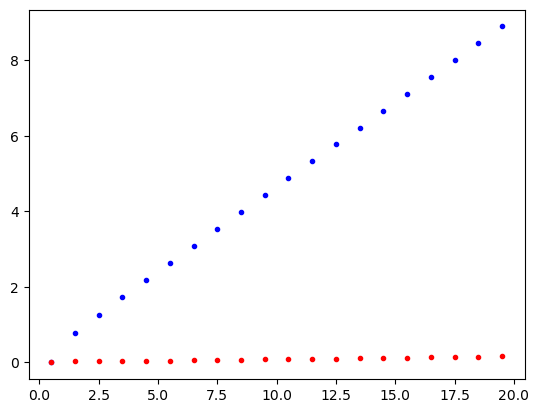

In [398]:
_J = np.arange(1/2,20.5)
plt.plot(_J, delta_on_e,'b.')
plt.plot(_J, delta_off_e,'r.')

In [376]:
(delta_off_e[-1] - delta_off_e[-2])

0.007994635836439556

In [385]:
(22+0.25-1/2)**2/(2*1350) - (22-0.25+1/2)**2/(2*1350) 

-0.008148148148148154

In [386]:
np.sqrt((22-0.25)**2+1350**2)-np.sqrt((22+0.25)**2+1350**2)

-0.008147066275114412

In [344]:
_J

[0.5]

In [302]:
out2.params['B'].value

0.252649390496936

In [298]:
J_data = np.array([1/2,3/2,3/2,5/2,5/2])
data_p-out2.params['B']*J_data*(J_data+1)

array([17651.26231296, 17650.91536479, 17651.68786479, 17650.65171783,
       17651.91031783])

(-1.0, 1.0)

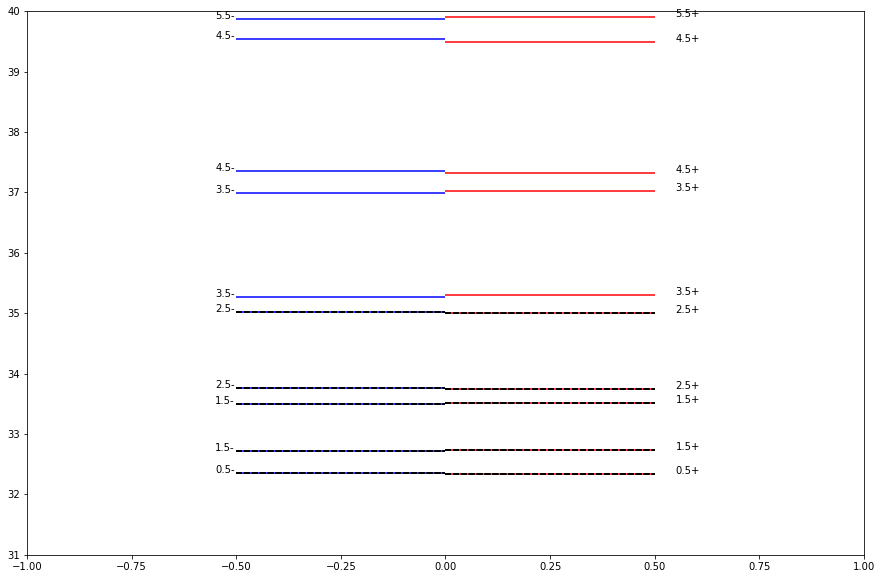

In [40]:
sub_B = False

plt.figure(figsize=(15,10))
off=[]
for J in np.arange(1/2,6):
    Hp = A010(J,1,out2.params)
    Hm = A010(J,-1,out2.params)
    vals_p,vecs_p = np.linalg.eigh(Hp)
    vals_m,vecs_m = np.linalg.eigh(Hm)
    if J==1/2:
        off = [min(vals_p),min(vals_m)]
#     print((vals_p-vals_m)*29979.2458)
    [plt.hlines(y=val,color='red',xmin=0.0,xmax=0.5) for val in vals_p]
    [plt.annotate(f'{J}+',(0.55,val)) for val in vals_p]
    [plt.hlines(y=val,color='blue',xmin=-0.5,xmax=-0.0) for val in vals_m]
    [plt.hlines(y=_p-min(data_p)+off[0],color='k',linestyle='--',xmin=0.0,xmax=0.5) for _p in data_p]
    [plt.hlines(y=_m-min(data_m)+off[1],color='k',linestyle='--',xmin=-0.5,xmax=0.0) for _m in data_m]
    [plt.annotate(f'{J}-',(-0.55,val)) for val in vals_m]

plt.ylim(31,40)
plt.xlim(-1,1)

In [550]:
print(off)

[32.33262353639491, 32.349161803808585]


In [472]:
Hp = A010(3/2,1,out2.params)
Hm = A010(3/2,-1,out2.params)
vals_p,vecs_p = np.linalg.eigh(Hp)
vals_m,vecs_m = np.linalg.eigh(Hm)

In [477]:
Hp

array([[ 3.47432612e+01, -4.79406415e-01, -3.76885586e-01],
       [-4.79406415e-01,  1.28676705e+03, -2.39456630e+01],
       [-3.76885586e-01, -2.39456630e+01,  3.51714279e+01]])

In [473]:
vals_p

array([  34.34200614,   35.11454148, 1287.22519202])

In [487]:
vecs_p.T

array([[-6.93419125e-01, -1.40390276e-02, -7.20397684e-01],
       [-7.20534368e-01,  1.29876635e-02,  6.93297588e-01],
       [ 3.76941257e-04, -9.99817096e-01,  1.91214961e-02]])

In [471]:
vecs_m

array([[-0.0192932 , -0.99981387],
       [-0.99981387,  0.0192932 ]])

In [ ]:
params_A010_SrOH={
    'Ts':,
    'Td':,
    'Bd':,
    'Bs-':,
    'Bs+':,
    'Dd':0,
    'Ds-':0,
    'Ds+':0,
    'A':,
    'AD':0,
    'e':,
    'gs-':,
    'gs+':,
    'gsD-':,
    'gsD+':,
    'qe':,
    'qv':,
    'pe+2qe':,
    'w2':,
}

def A010_SrOH(J,parity,params):
    n=4
    Ts=0
    H = np.zeros((n,n))
    z=np.sqrt(J+1/2)
    Ad = params['A']*(1-3/4*params['e']**2)
    As = params['A']*(1-1/4*params['e']**2)
    AdD = params['AD']*(1-3/4*params['e']**2)
    AsD = params['AD']*(1-1/4*params['e']**2)
    H[0,0] = params['Ts']-params['Td']+params['Bd']*(z-6)-params['Dd'] (z**2-11*z+32)+1/2*(Ad+AdD*(z-6))
    H[0,1] = -params['Bd']*np.sqrt(z-4)+2*params['Dd']*(z-4)**(3/2)
    H[1,0] = H[0,1]
    H[1,1] = params['Ts'] - params['Td'] + params['Bd']*(z-2) - params['Dd']*z*(z-3)-1/2*(Ad+AdD*(z-2))
    H[0,2] = 1/2*params['qv']*(z**2-5*z+4)**(1/2)
    H[2,0] = H[0,2]
    H[1,2] = (z-1)**(1/2)*(parity*1/2*(params['qe']*z**(1/2)-params['qv']))
    H[2,1] = H[1,2]
    H[2,2] = params['Ts'] - 1/2*(As+AsD*z) - parity*1/2*params['gs-']*z**(1/2)+params['Bs-']*z-params['Ds-']*z*(z+1)-parity*params['gs-D']*z**(1/2)*(z+1+parity*z**(1/2))
    H[0,3] = parity*params['qe']*(z**2 - 5*z + 4)**(1/2)
    H[3,0] = H[0,3]
    H[1,3] = (z-1)**(1/2)*(-parity/2*params['pe+2qe']+1/2*params['qv']*z**(1/2))
    H[3,1] = H[1,3]
    H[2,3] = -1/2*(params['Bs-']+params['Bs+'])*z**(1/2) + (params['Ds-']+params['Ds+'])*z**(3/2)+params['e']*params['w2']
    H[3,2] = H[2,3]
    H[3,3] = params['Ts'] - 1/2*(As+AsD*z)+parity*params['gs+']*z**(1/2)+params['Bs+']*z - params['Ds+']*z*(z+1)+parity/2*params['gs+d']*z**(1/2)*(z+1-parity*2*z**(1/2))
    return H